## Data Loading and Preprocessing

Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Input, concatenate, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set the visual style for plots
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Load the dataset
batting = pd.read_csv('ODI_batting.csv')
bowling = pd.read_csv('ODI_bowling.csv')
player_info = pd.read_csv('all_players.csv')

# Display the first few rows of each dataset
print("Batting Data Preview:")
display(batting.head())

print("\nBowling Data Preview:")
display(bowling.head())

print("\nPlayer Info Preview:")
display(player_info.head())


Batting Data Preview:


,id,span,matches,innings,not_out,runs,high_score,average_score,ball_faced,strike_rate,100s,50,0s,4s,6s
0,420402,2014-2017,17,16.0,1.0,264.0,60,17.60,488.0,54.09,0.0,2.0,3.0,15.0,0.0
1,921509,2019-2022,8,8.0,1.0,433.0,162,61.85,497.0,87.12,3.0,0.0,0.0,45.0,5.0
2,568136,2014-2022,11,3.0,3.0,7.0,6*,NaN,21.0,33.33,0.0,0.0,0.0,0.0,0.0
3,819429,2021-2022,7,4.0,1.0,35.0,15*,11.66,56.0,62.50,0.0,0.0,0.0,5.0,0.0
4,440970,2013-2022,53,53.0,7.0,1505.0,97*,32.71,2295.0,65.57,0.0,13.0,4.0,128.0,9.0



Bowling Data Preview:


,id,sp,bbi,bbm,bl,bwa,bwe,bwsr,cd,fw,fwk,in,md,mt,ov,pr,tw,wk
0,935995,2020-2022,Jan-00,Jan-00,NaN,22.66,4.97,27.3,68.0,0.0,0.0,8.0,1.0,22,13.4,NaN,0.0,3.0
1,932355,2022-2022,Apr-47,Apr-47,NaN,19.09,5.94,19.2,210.0,0.0,1.0,4.0,1.0,4,35.2,NaN,0.0,11.0
2,380354,2012-2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,NaN,NaN,NaN,NaN
3,926629,2021-2022,28-Mar,28-Mar,NaN,32.00,5.90,32.5,256.0,0.0,0.0,6.0,3.0,6,43.2,NaN,0.0,8.0
4,536936,2015-2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,NaN,NaN,NaN,NaN



Player Info Preview:


,id,name,gender,bating_style,bowling_style,playing_role,country_id
0,935995,Afif Hossain,M,left-hand bat,right-arm offbreak,allrounder,25
1,380354,Anamul Haque,M,right-hand bat,NaN,wicketkeeper batter,25
2,1346729,Dilara Akter,F,right-hand bat,NaN,wicketkeeper batter,25
3,932355,Ebadot Hossain,M,right-hand bat,right-arm fast-medium,bowler,25
4,627048,Fahima Khatun,F,right-hand bat,legbreak,bowler,25


In [3]:
# Check the dimensions of the datasets
print(f"Batting dataset shape: {batting.shape}")
print(f"Bowling dataset shape: {bowling.shape}")
print(f"Player info dataset shape: {player_info.shape}")


Batting dataset shape: (347, 15)
Bowling dataset shape: (347, 18)
Player info dataset shape: (666, 7)


In [4]:
# Summary statistics for batting data
print("\nBatting Data Summary Statistics:")
display(batting.describe())

# Summary statistics for bowling data
print("\nBowling Data Summary Statistics:")
display(bowling.describe())


Batting Data Summary Statistics:


,id,matches,innings,not_out,runs,average_score,ball_faced,strike_rate,100s,50,0s,4s,6s
count,3.470000e+02,347.000000,339.000000,339.000000,339.000000,326.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000
mean,5.374333e+05,43.870317,35.775811,6.545723,973.834808,24.268988,1136.126844,79.573510,1.646018,5.230088,2.740413,87.967552,18.067847
std,2.939291e+05,52.437609,47.198027,8.908151,1750.439129,14.994277,2012.359163,25.536322,4.551975,10.213701,3.512933,165.066121,33.816308
min,5.334000e+03,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.267010e+05,7.000000,5.000000,1.000000,58.000000,12.332500,75.500000,67.715000,0.000000,0.000000,0.000000,5.000000,1.000000
50%,4.818960e+05,22.000000,17.000000,3.000000,250.000000,22.445000,299.000000,82.130000,0.000000,1.000000,2.000000,19.000000,5.000000
75%,7.007560e+05,61.000000,47.000000,9.000000,1028.500000,34.340000,1146.000000,91.325000,1.000000,5.000000,4.000000,90.000000,19.000000
max,1.246528e+06,271.000000,262.000000,50.000000,12809.000000,82.500000,13660.000000,200.000000,46.000000,64.000000,19.000000,1204.000000,273.000000



Bowling Data Summary Statistics:


,id,bl,bwa,bwe,bwsr,cd,fw,fwk,in,md,mt,ov,pr,tw,wk
count,3.470000e+02,0.0,237.000000,268.000000,237.000000,268.000000,268.000000,268.000000,268.000000,268.000000,347.000000,268.000000,0.0,268.0,268.000000
mean,5.374333e+05,NaN,40.637932,5.717239,44.243460,1133.578358,0.414179,1.085821,29.723881,9.104478,43.870317,216.850746,NaN,0.0,34.555970
std,2.939291e+05,NaN,22.416987,1.351011,22.256418,1531.510042,0.957967,2.157667,37.939414,16.724813,52.437609,304.376069,NaN,0.0,50.185206
min,5.334000e+03,NaN,3.000000,2.000000,3.500000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.500000,NaN,0.0,0.000000
25%,3.267010e+05,NaN,28.660000,5.037500,32.100000,122.000000,0.000000,0.000000,4.000000,0.000000,7.000000,23.000000,NaN,0.0,3.000000
50%,4.818960e+05,NaN,35.360000,5.530000,39.000000,433.000000,0.000000,0.000000,13.000000,2.000000,22.000000,76.050000,NaN,0.0,12.000000
75%,7.007560e+05,NaN,46.000000,6.022500,50.000000,1579.500000,0.250000,1.000000,41.000000,10.000000,61.000000,278.525000,NaN,0.0,44.250000
max,1.246528e+06,NaN,202.000000,14.400000,180.000000,8544.000000,8.000000,12.000000,221.000000,125.000000,271.000000,1921.500000,NaN,0.0,294.000000


In [5]:
# Check for missing values
print("\nMissing Values in Batting Data:")
display(batting.isnull().sum())

print("\nMissing Values in Bowling Data:")
display(bowling.isnull().sum())

print("\nMissing Values in Player Info Data:")
display(player_info.isnull().sum())


Missing Values in Batting Data:


id                0
span             19
matches           0
innings           8
not_out           8
runs              8
high_score        8
average_score    21
ball_faced        8
strike_rate       8
100s              8
50                8
0s                8
4s                8
6s                8
dtype: int64


Missing Values in Bowling Data:


id        0
sp       19
bbi     110
bbm     110
bl      347
bwa     110
bwe      79
bwsr    110
cd       79
fw       79
fwk      79
in       79
md       79
mt        0
ov       79
pr      347
tw       79
wk       79
dtype: int64


Missing Values in Player Info Data:


id                0
name              0
gender            0
bating_style      0
bowling_style    84
playing_role     32
country_id        0
dtype: int64

In [6]:
# Function to handle missing values
def handle_missing_values(df):
    # For numerical columns, fill with median
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # For categorical columns, fill with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    return df

# Apply the function to each dataset
batting = handle_missing_values(batting)
bowling = handle_missing_values(bowling)
player_info = handle_missing_values(player_info)

# Verify that missing values have been handled
print("Missing Values After Handling:")
print("Batting:", batting.isnull().sum().sum())
print("Bowling:", bowling.isnull().sum().sum())
print("Player Info:", player_info.isnull().sum().sum())

Missing Values After Handling:
Batting: 0
Bowling: 694
Player Info: 0


In [7]:
# Merge the datasets on player_id
player_stats = pd.merge(batting, bowling, on='id', how='outer', suffixes=('_batting', '_bowling'))
player_stats = pd.merge(player_stats, player_info, on='id', how='left')

# Fill missing values that may have been created during the merge
player_stats = handle_missing_values(player_stats)

# Display the merged dataset
print("Merged Dataset Preview:")
display(player_stats.head())
print(f"Merged dataset shape: {player_stats.shape}")

Merged Dataset Preview:


,id,span,matches,innings,not_out,runs,high_score,average_score,ball_faced,strike_rate,...,ov,pr,tw,wk,name,gender,bating_style,bowling_style,playing_role,country_id
0,5334,2013-2022,146,142.0,3.0,5406.0,153*,38.89,6162.0,87.73,...,47.20,NaN,0.0,4.0,AJ Finch,M,right-hand bat,slow left-arm orthodox,top-order batter,2
1,8608,2002-2015,194,79.0,43.0,273.0,28,7.58,561.0,48.66,...,1597.20,NaN,0.0,269.0,JM Anderson,M,left-hand bat,right-arm fast-medium,bowler,1
2,8917,2014-2023,126,100.0,15.0,2154.0,128,25.34,2152.0,100.09,...,909.00,NaN,0.0,96.0,MM Ali,M,left-hand bat,right-arm offbreak,batting allrounder,1
3,10617,2006-2016,121,68.0,25.0,529.0,45*,12.30,709.0,74.61,...,1018.10,NaN,0.0,178.0,SCJ Broad,M,left-hand bat,right-arm fast-medium,bowler,1
4,24598,2006-2022,248,230.0,34.0,7701.0,148,39.29,8447.0,91.16,...,76.05,NaN,0.0,12.0,EJG Morgan,M,left-hand bat,right-arm medium,middle-order batter,1


Merged dataset shape: (347, 38)


In [8]:
player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             347 non-null    int64  
 1   span           347 non-null    object 
 2   matches        347 non-null    int64  
 3   innings        347 non-null    float64
 4   not_out        347 non-null    float64
 5   runs           347 non-null    float64
 6   high_score     347 non-null    object 
 7   average_score  347 non-null    float64
 8   ball_faced     347 non-null    float64
 9   strike_rate    347 non-null    float64
 10  100s           347 non-null    float64
 11  50             347 non-null    float64
 12  0s             347 non-null    float64
 13  4s             347 non-null    float64
 14  6s             347 non-null    float64
 15  sp             347 non-null    object 
 16  bbi            347 non-null    object 
 17  bbm            347 non-null    object 
 18  bl        

## Exploratory Data Analysis

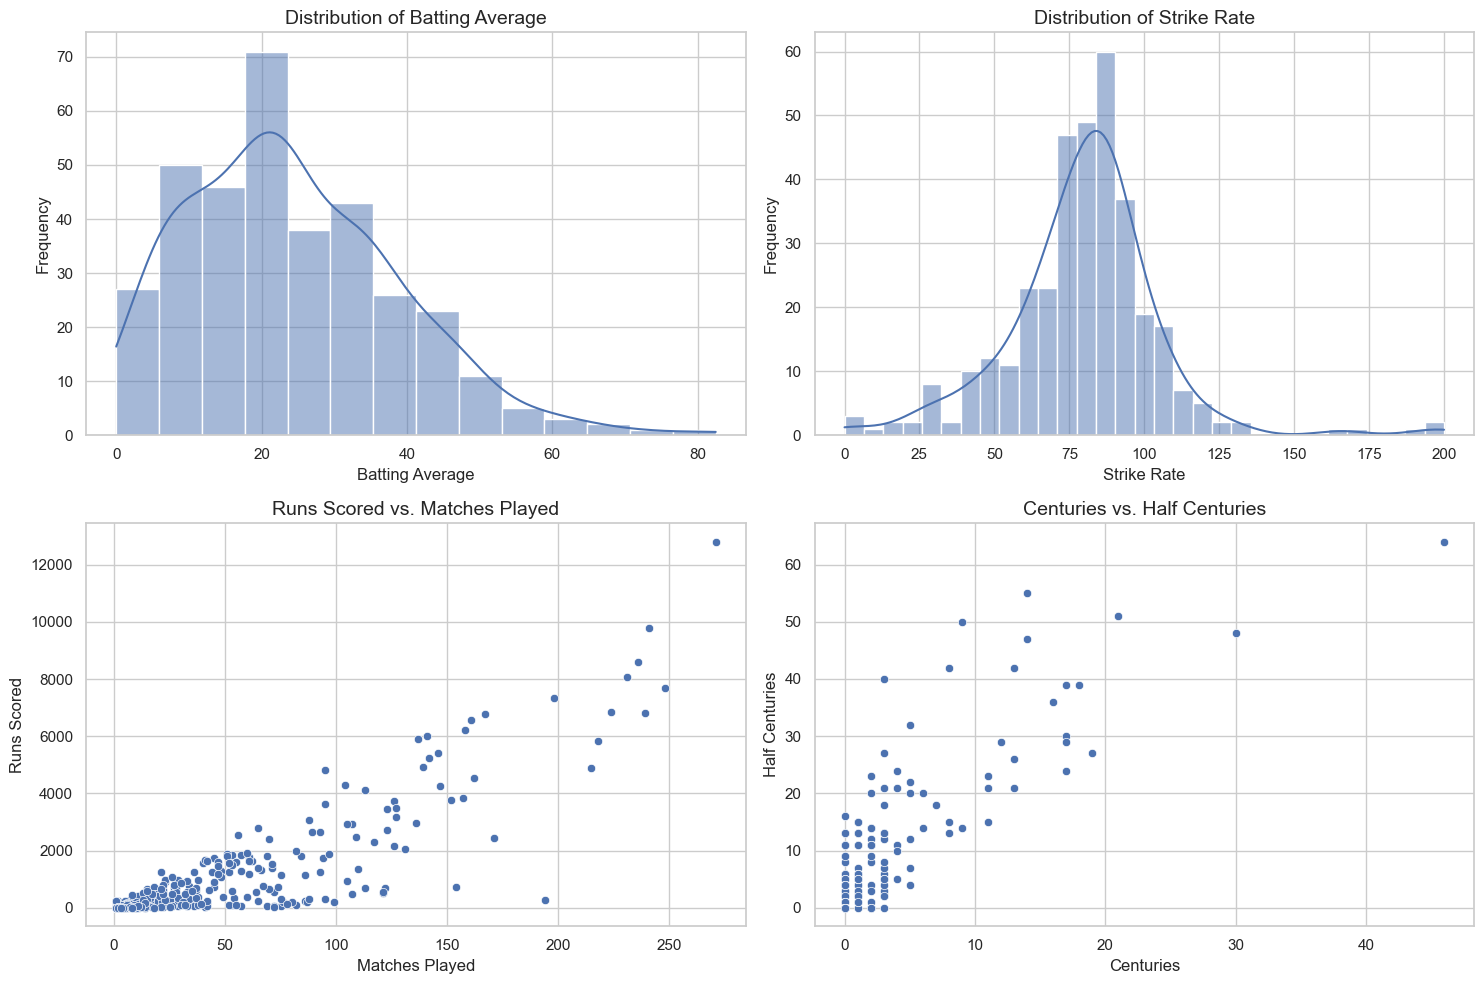

In [9]:
# Create a figure for batting performance visualization
plt.figure(figsize=(15, 10))

# Plot batting average distribution
plt.subplot(2, 2, 1)
sns.histplot(player_stats['average_score'], kde=True)
plt.title('Distribution of Batting Average', fontsize=14)
plt.xlabel('Batting Average')
plt.ylabel('Frequency')

# Plot strike rate distribution
plt.subplot(2, 2, 2)
sns.histplot(player_stats['strike_rate'], kde=True)
plt.title('Distribution of Strike Rate', fontsize=14)
plt.xlabel('Strike Rate')
plt.ylabel('Frequency')

# Plot runs scored vs matches played
plt.subplot(2, 2, 3)
sns.scatterplot(x='matches', y='runs', data=player_stats)
plt.title('Runs Scored vs. Matches Played', fontsize=14)
plt.xlabel('Matches Played')
plt.ylabel('Runs Scored')

# Plot centuries vs half-centuries
plt.subplot(2, 2, 4)
sns.scatterplot(x='100s', y='50', data=player_stats)
plt.title('Centuries vs. Half Centuries', fontsize=14)
plt.xlabel('Centuries')
plt.ylabel('Half Centuries')

plt.tight_layout()
plt.show()


bowling performance metrics

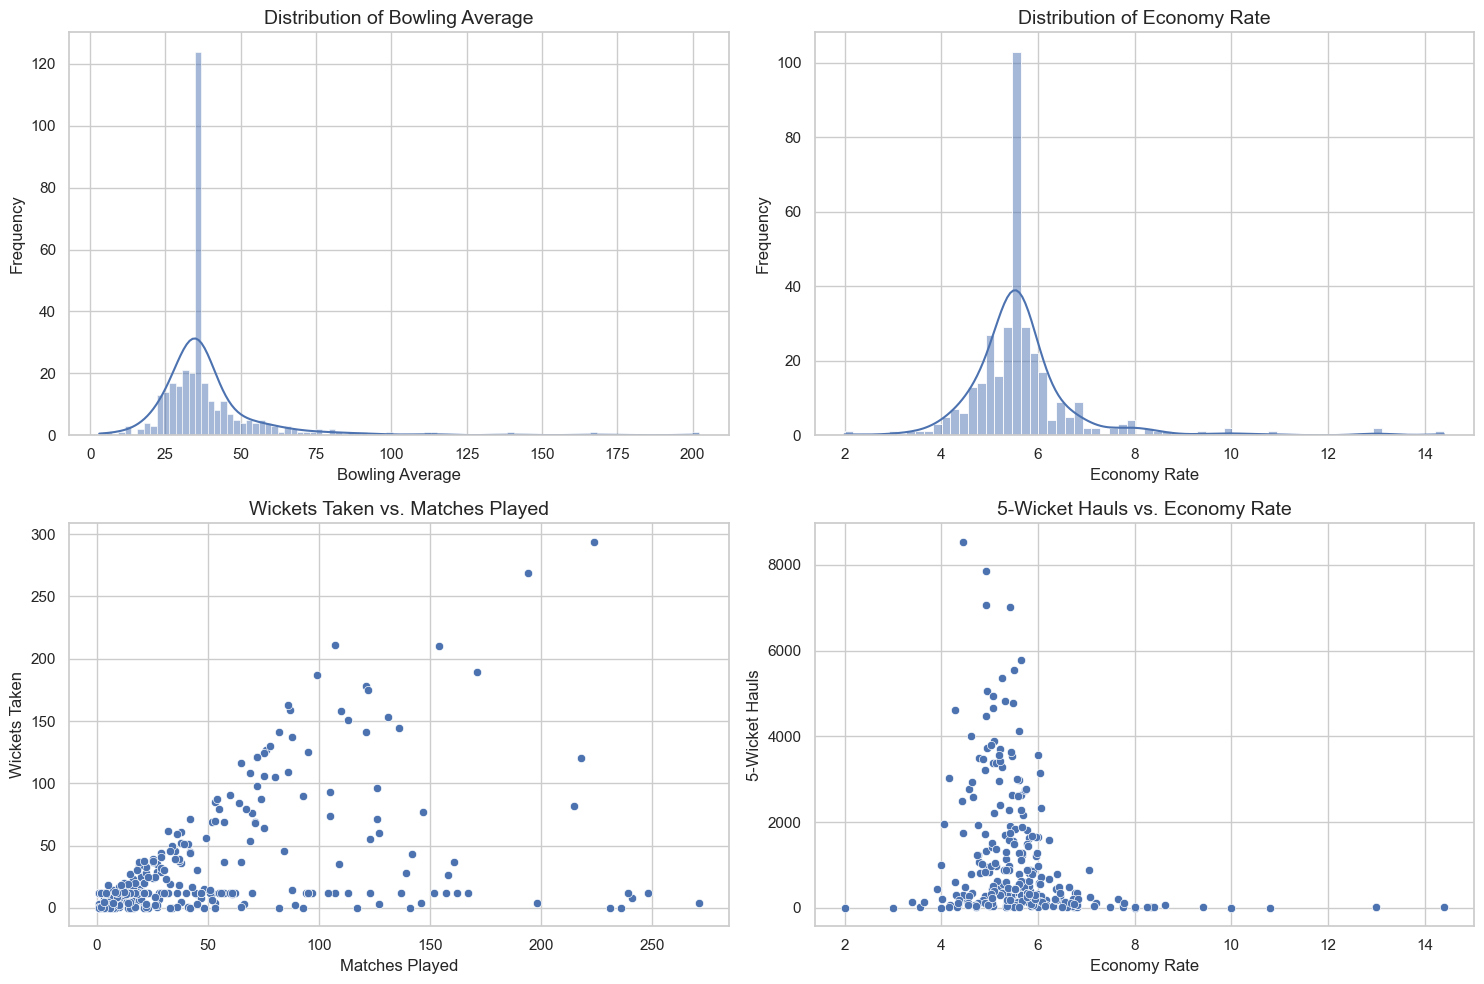

In [10]:
# Create a figure for bowling performance visualization
plt.figure(figsize=(15, 10))

# Plot bowling average distribution
plt.subplot(2, 2, 1)
sns.histplot(player_stats['bwa'], kde=True)
plt.title('Distribution of Bowling Average', fontsize=14)
plt.xlabel('Bowling Average')
plt.ylabel('Frequency')

# Plot economy rate distribution
plt.subplot(2, 2, 2)
sns.histplot(player_stats['bwe'], kde=True)
plt.title('Distribution of Economy Rate', fontsize=14)
plt.xlabel('Economy Rate')
plt.ylabel('Frequency')

# Plot wickets taken vs matches played
plt.subplot(2, 2, 3)
sns.scatterplot(x='matches', y='wk', data=player_stats)
plt.title('Wickets Taken vs. Matches Played', fontsize=14)
plt.xlabel('Matches Played')
plt.ylabel('Wickets Taken')

# Plot 5-wicket hauls vs economy rate
plt.subplot(2, 2, 4)
sns.scatterplot(x='bwe', y='cd', data=player_stats)
plt.title('5-Wicket Hauls vs. Economy Rate', fontsize=14)
plt.xlabel('Economy Rate')
plt.ylabel('5-Wicket Hauls')

plt.tight_layout()
plt.show()


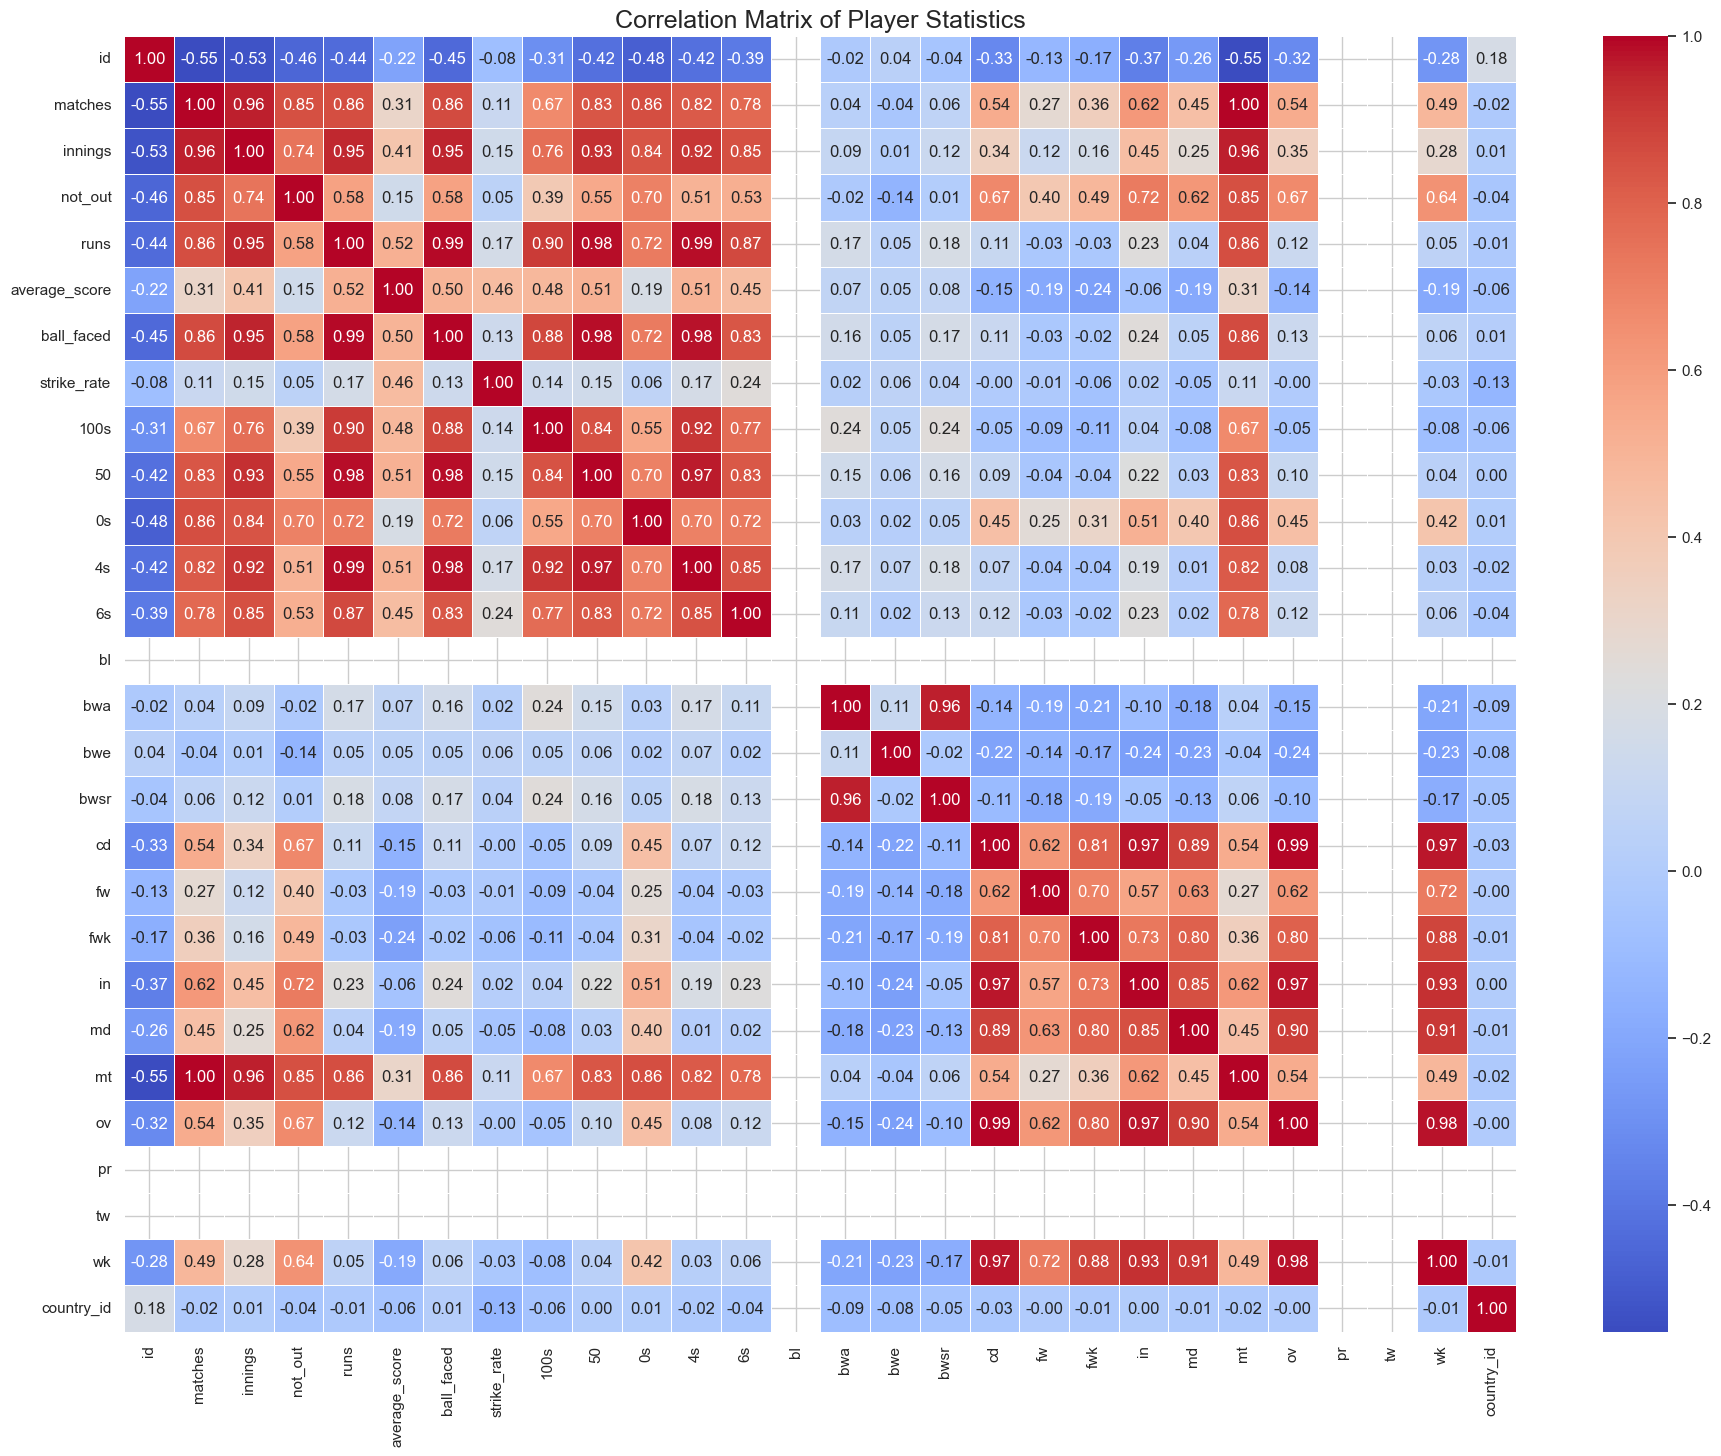

In [11]:
# Select only numerical columns for correlation analysis
numerical_cols = player_stats.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = player_stats[numerical_cols].corr()

# Create a heatmap of correlations
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Player Statistics', fontsize=18)
plt.show()


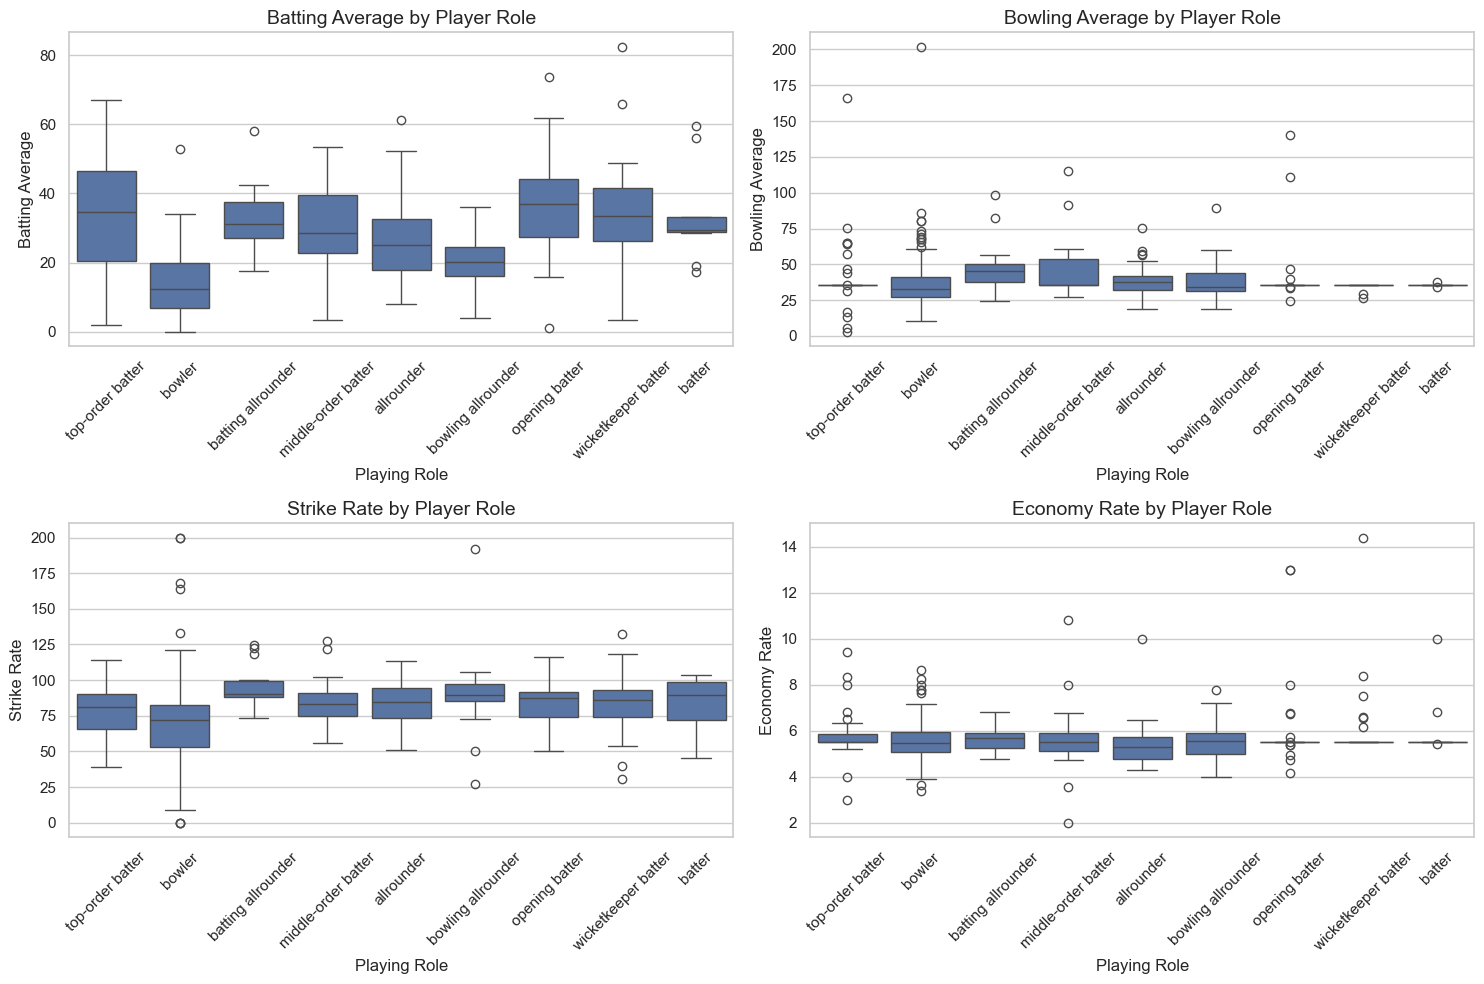

In [12]:
# Plot performance by player role
plt.figure(figsize=(15, 10))

# Batting average by player role
plt.subplot(2, 2, 1)
sns.boxplot(x='playing_role', y='average_score', data=player_stats)
plt.title('Batting Average by Player Role', fontsize=14)
plt.xlabel('Playing Role')
plt.ylabel('Batting Average')
plt.xticks(rotation=45)

# Bowling average by player role
plt.subplot(2, 2, 2)
sns.boxplot(x='playing_role', y='bwa', data=player_stats)
plt.title('Bowling Average by Player Role', fontsize=14)
plt.xlabel('Playing Role')
plt.ylabel('Bowling Average')
plt.xticks(rotation=45)

# Strike rate by player role
plt.subplot(2, 2, 3)
sns.boxplot(x='playing_role', y='strike_rate', data=player_stats)
plt.title('Strike Rate by Player Role', fontsize=14)
plt.xlabel('Playing Role')
plt.ylabel('Strike Rate')
plt.xticks(rotation=45)

# Economy rate by player role
plt.subplot(2, 2, 4)
sns.boxplot(x='playing_role', y='bwe', data=player_stats)
plt.title('Economy Rate by Player Role', fontsize=14)
plt.xlabel('Playing Role')
plt.ylabel('Economy Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


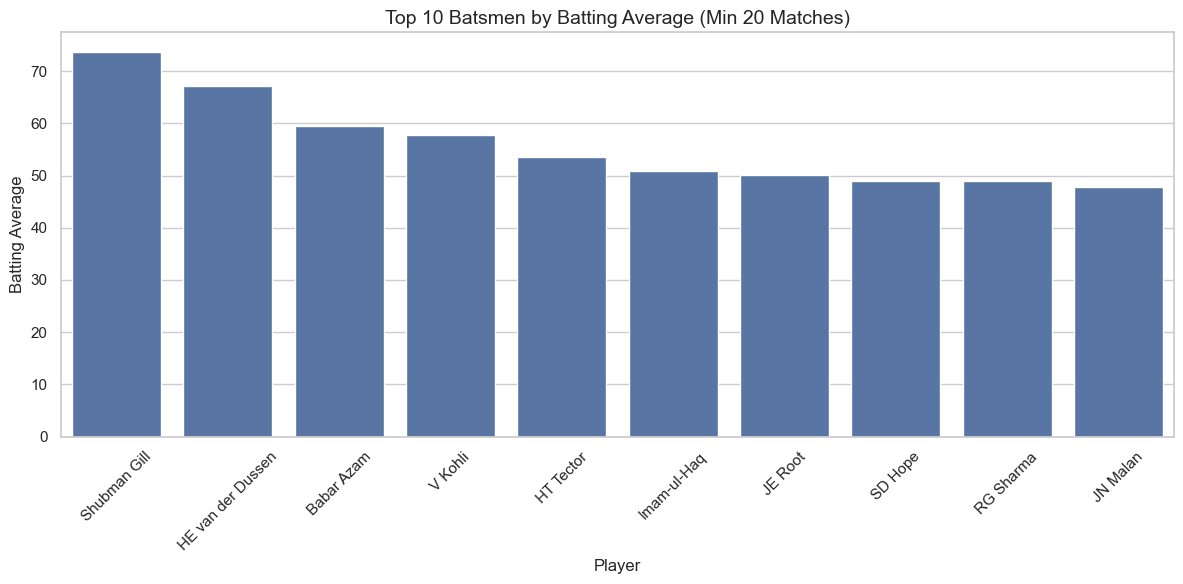

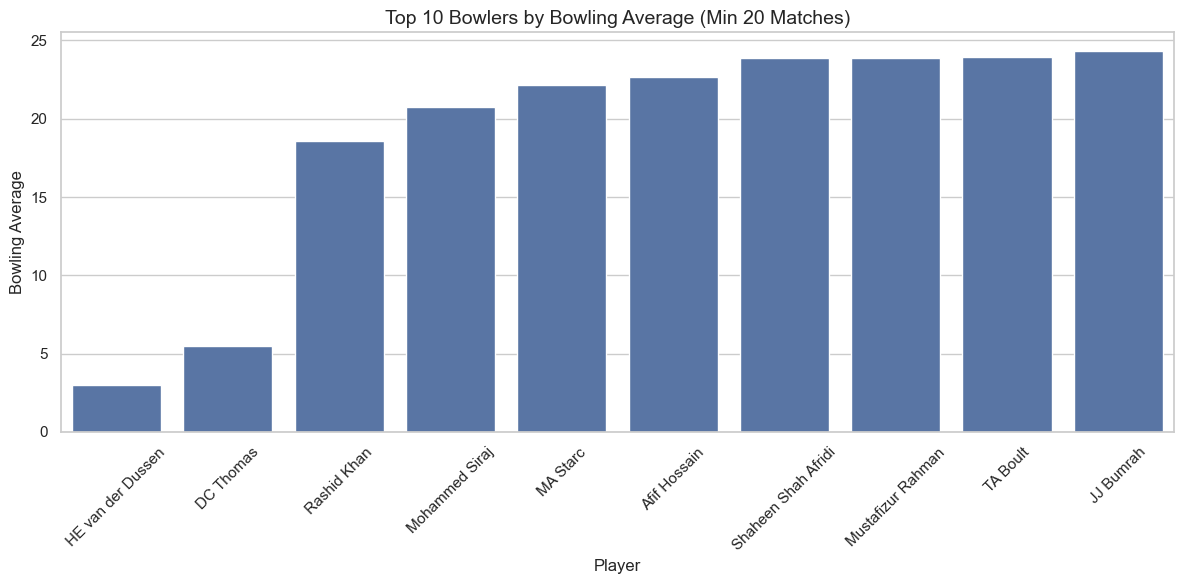

In [13]:
# Top 10 batsmen by batting average (min 20 matches)
top_batsmen = player_stats[player_stats['matches'] >= 20].nlargest(10, 'average_score')
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='average_score', data=top_batsmen)
plt.title('Top 10 Batsmen by Batting Average (Min 20 Matches)', fontsize=14)
plt.xlabel('Player')
plt.ylabel('Batting Average')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 bowlers by bowling average (min 20 matches, lower is better)
top_bowlers = player_stats[(player_stats['matches'] >= 20) & 
                           (player_stats['wk'] > 0)].nsmallest(10, 'bwa')
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='bwa', data=top_bowlers)
plt.title('Top 10 Bowlers by Bowling Average (Min 20 Matches)', fontsize=14)
plt.xlabel('Player')
plt.ylabel('Bowling Average')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Feature Engineering and Selection

In [14]:
# Feature Engineering
player_stats['batting_impact'] = (player_stats['average_score'] * player_stats['strike_rate']) / 100
player_stats['bowling_impact'] = (player_stats['wk'] / player_stats['matches']) * (1 / player_stats['bwe'])
player_stats['all_round_index'] = player_stats['batting_impact'] + player_stats['bowling_impact']

# Calculate consistency metrics
player_stats['batting_consistency'] = player_stats['50'] / player_stats['innings']
player_stats['bowling_consistency'] = player_stats['wk'] / player_stats['ov']

# Calculate recent form (assuming we have recent performance data)
# For demonstration purposes, we'll simulate recent form with random values
np.random.seed(42)
player_stats['recent_batting_form'] = np.random.normal(
    player_stats['average_score'], player_stats['average_score'] * 0.2)
player_stats['recent_bowling_form'] = np.random.normal(
    player_stats['bwa'], player_stats['bwa'] * 0.2)

# Handle infinite and NaN values
player_stats.replace([np.inf, -np.inf], np.nan, inplace=True)
player_stats = handle_missing_values(player_stats)

# Display the engineered features
print("Preview of Engineered Features:")
display(player_stats[['name', 'batting_impact', 'bowling_impact', 
                      'all_round_index', 'batting_consistency', 'bowling_consistency',
                      'recent_batting_form', 'recent_bowling_form']].head())


Preview of Engineered Features:


,name,batting_impact,bowling_impact,all_round_index,batting_consistency,bowling_consistency,recent_batting_form,recent_bowling_form
0,AJ Finch,34.118197,0.005009,34.123206,0.211268,0.084746,42.753443,46.523344
1,JM Anderson,3.688428,0.281829,3.970257,0.000000,0.168420,7.370391,25.021412
2,MM Ali,25.362806,0.143485,25.506291,0.060000,0.105611,28.622486,48.162295
3,SCJ Broad,9.177030,0.279672,9.456702,0.000000,0.174835,16.046653,32.003529
4,EJG Morgan,35.816764,0.008750,35.825514,0.204348,0.157791,37.450023,45.793719


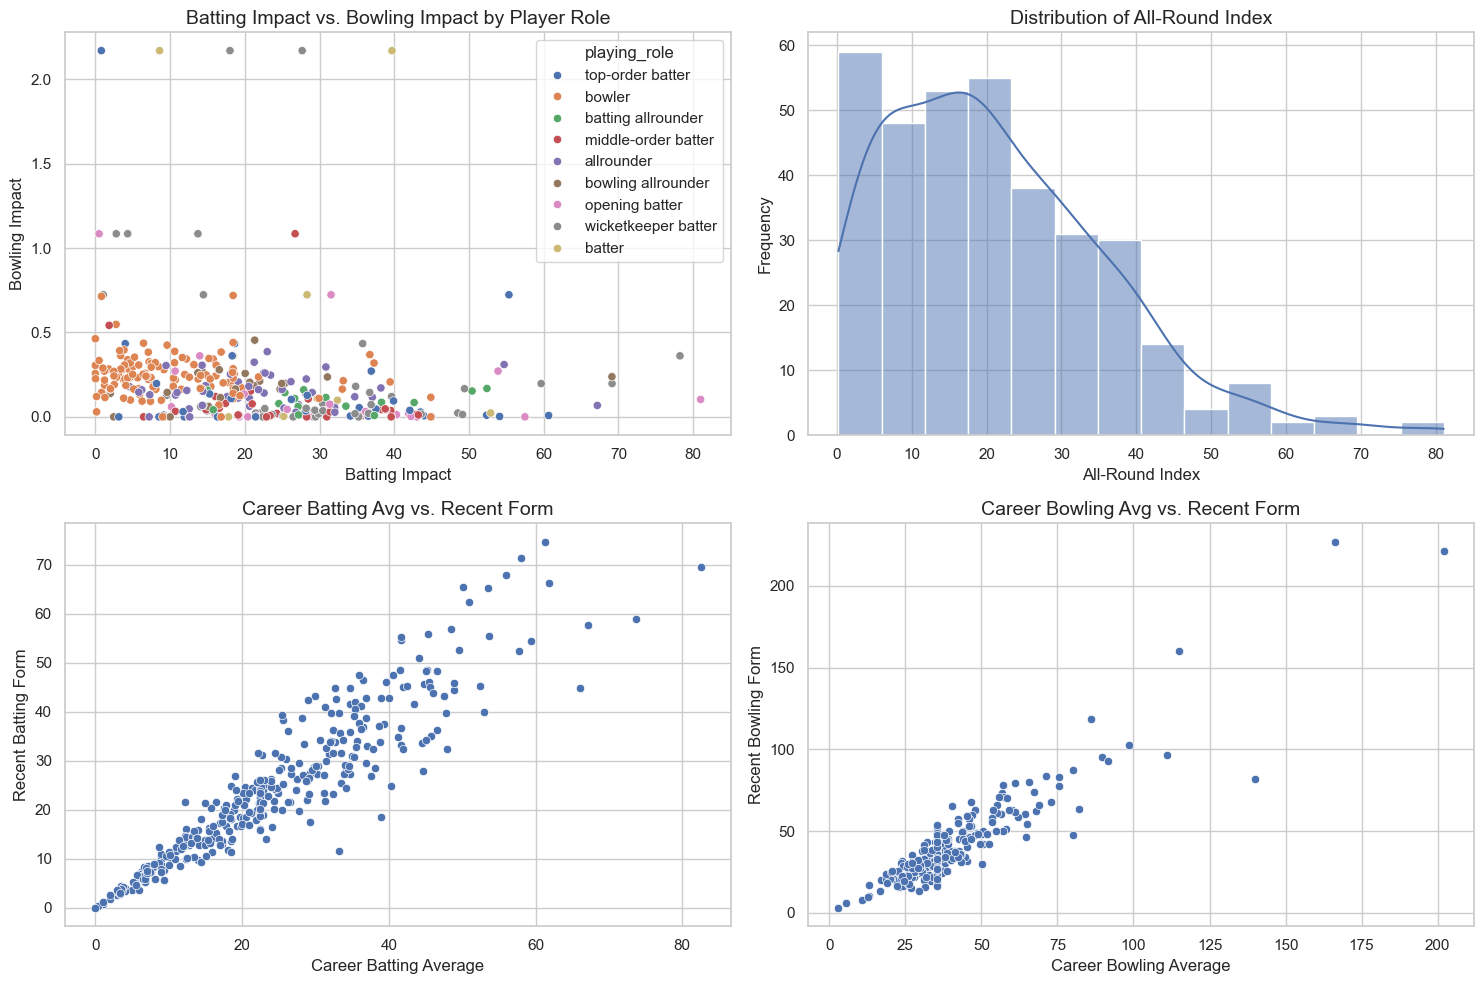

In [15]:
# Visualize the engineered features
plt.figure(figsize=(15, 10))

# Batting Impact vs Bowling Impact
plt.subplot(2, 2, 1)
sns.scatterplot(x='batting_impact', y='bowling_impact', hue='playing_role', data=player_stats)
plt.title('Batting Impact vs. Bowling Impact by Player Role', fontsize=14)
plt.xlabel('Batting Impact')
plt.ylabel('Bowling Impact')

# All-Round Index Distribution
plt.subplot(2, 2, 2)
sns.histplot(player_stats['all_round_index'], kde=True)
plt.title('Distribution of All-Round Index', fontsize=14)
plt.xlabel('All-Round Index')
plt.ylabel('Frequency')

# Recent Form Comparison
plt.subplot(2, 2, 3)
sns.scatterplot(x='average_score', y='recent_batting_form', data=player_stats)
plt.title('Career Batting Avg vs. Recent Form', fontsize=14)
plt.xlabel('Career Batting Average')
plt.ylabel('Recent Batting Form')

plt.subplot(2, 2, 4)
sns.scatterplot(x='bwa', y='recent_bowling_form', data=player_stats)
plt.title('Career Bowling Avg vs. Recent Form', fontsize=14)
plt.xlabel('Career Bowling Average')
plt.ylabel('Recent Bowling Form')

plt.tight_layout()
plt.show()


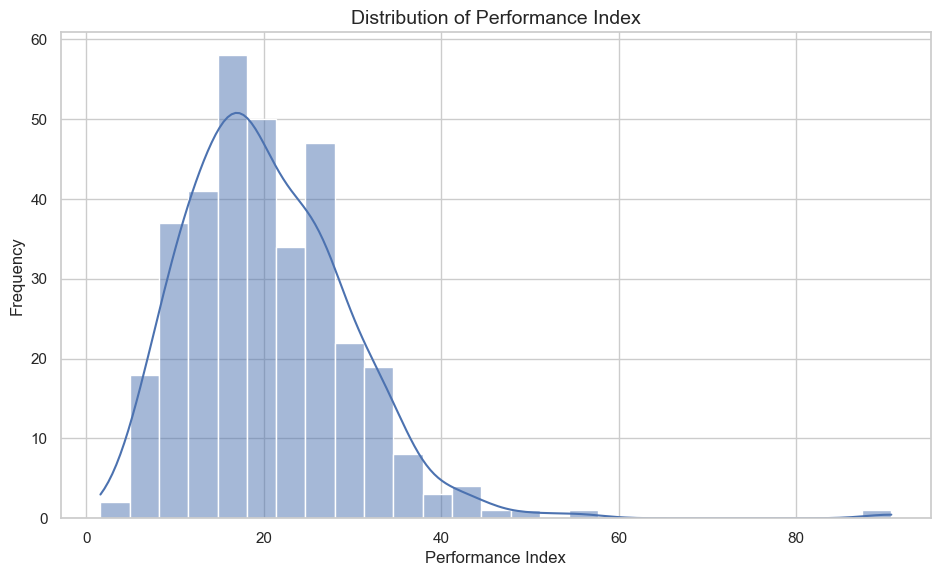

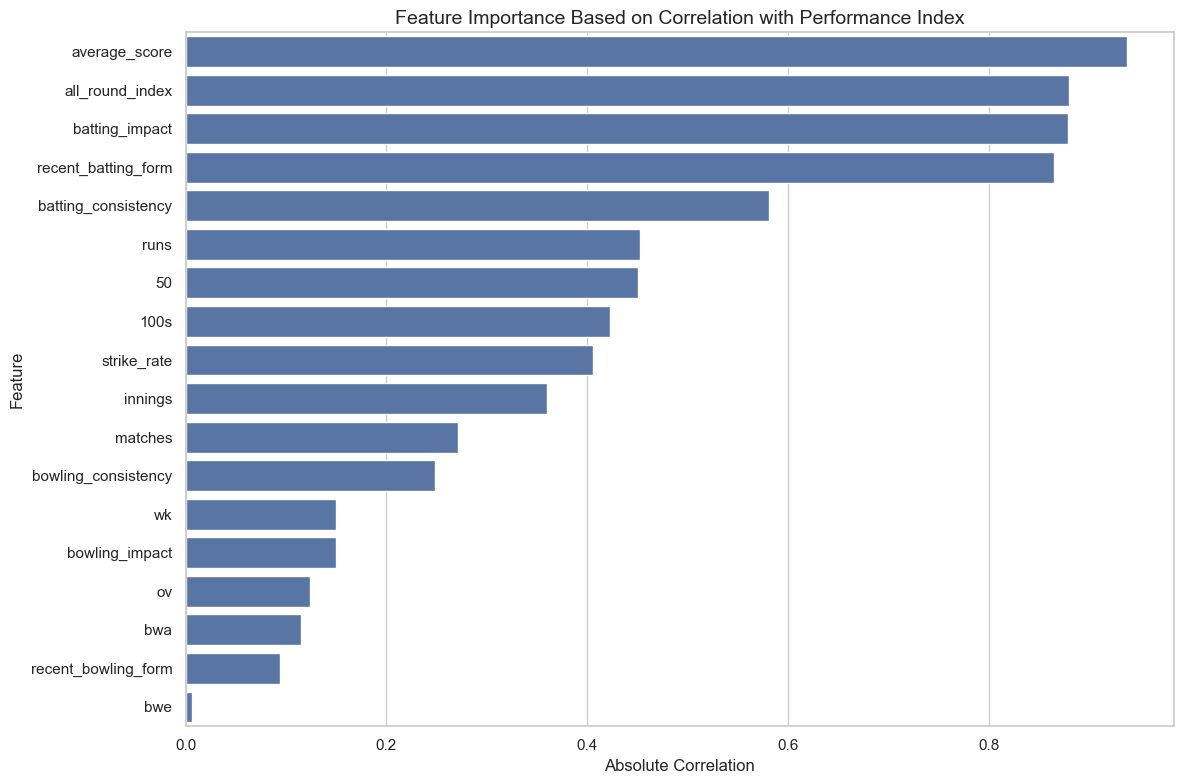

Top Features Selected: ['average_score', 'all_round_index', 'batting_impact', 'recent_batting_form', 'batting_consistency', 'runs', '50', '100s', 'strike_rate', 'innings']


In [16]:
# Prepare feature set for modeling
features = ['matches', 'innings', 'runs', 'average_score', 
            'strike_rate', '100s', '50', 'ov', 
            'wk', 'bwa', 'bwe', 'batting_impact', 
            'bowling_impact', 'all_round_index', 'batting_consistency', 
            'bowling_consistency', 'recent_batting_form', 'recent_bowling_form']

# Target variable: For simplicity, let's create a performance index
# Higher value means better overall performance
player_stats['performance_index'] = (
    player_stats['average_score'] / player_stats['average_score'].max() * 50 +
    (1 / (player_stats['bwa'] + 1)) / (1 / (player_stats['bwa'] + 1)).max() * 50
)

# Visualize the distribution of performance index
plt.figure(figsize=(10, 6))
sns.histplot(player_stats['performance_index'], kde=True)
plt.title('Distribution of Performance Index', fontsize=14)
plt.xlabel('Performance Index')
plt.ylabel('Frequency')
plt.show()

# Select relevant features using correlation with target
target = 'performance_index'
feature_importance = pd.DataFrame({'Feature': features,
                                   'Correlation': [abs(player_stats[f].corr(player_stats[target])) for f in features]})
feature_importance = feature_importance.sort_values('Correlation', ascending=False)

# Visualize feature importance based on correlation
plt.figure(figsize=(12, 8))
sns.barplot(x='Correlation', y='Feature', data=feature_importance)
plt.title('Feature Importance Based on Correlation with Performance Index', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Select top features based on correlation
top_features = feature_importance.head(10)['Feature'].tolist()
print("Top Features Selected:", top_features)


In [17]:
# Prepare X and y for modeling
X = player_stats[top_features]
y = player_stats[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training data shape:", X_train_scaled.shape)
print("Testing data shape:", X_test_scaled.shape)

Training data shape: (277, 10)
Testing data shape: (70, 10)


## Baseline ML Models

In [18]:
# Function to evaluate regression models
def evaluate_regression_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return {'model': model_name, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# 1. Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_preds = dt_model.predict(X_test_scaled)
dt_metrics = evaluate_regression_model(y_test, dt_preds, "Decision Tree")

# 2. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)
rf_metrics = evaluate_regression_model(y_test, rf_preds, "Random Forest")

# 3. XGBoost Regressor
xgb_model = XGBRegressor.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_preds = xgb_model.predict(X_test_scaled)
xgb_metrics = evaluate_regression_model(y_test, xgb_preds, "XGBoost")

# Collect all baseline model metrics
baseline_metrics = [dt_metrics, rf_metrics, xgb_metrics]


Decision Tree Evaluation Metrics:
Mean Squared Error (MSE): 18.9140
Root Mean Squared Error (RMSE): 4.3490
Mean Absolute Error (MAE): 2.5476
R² Score: 0.7377
Random Forest Evaluation Metrics:
Mean Squared Error (MSE): 8.4996
Root Mean Squared Error (RMSE): 2.9154
Mean Absolute Error (MAE): 1.5772
R² Score: 0.8821
XGBoost Evaluation Metrics:
Mean Squared Error (MSE): 27.4798
Root Mean Squared Error (RMSE): 5.2421
Mean Absolute Error (MAE): 2.0353
R² Score: 0.6190


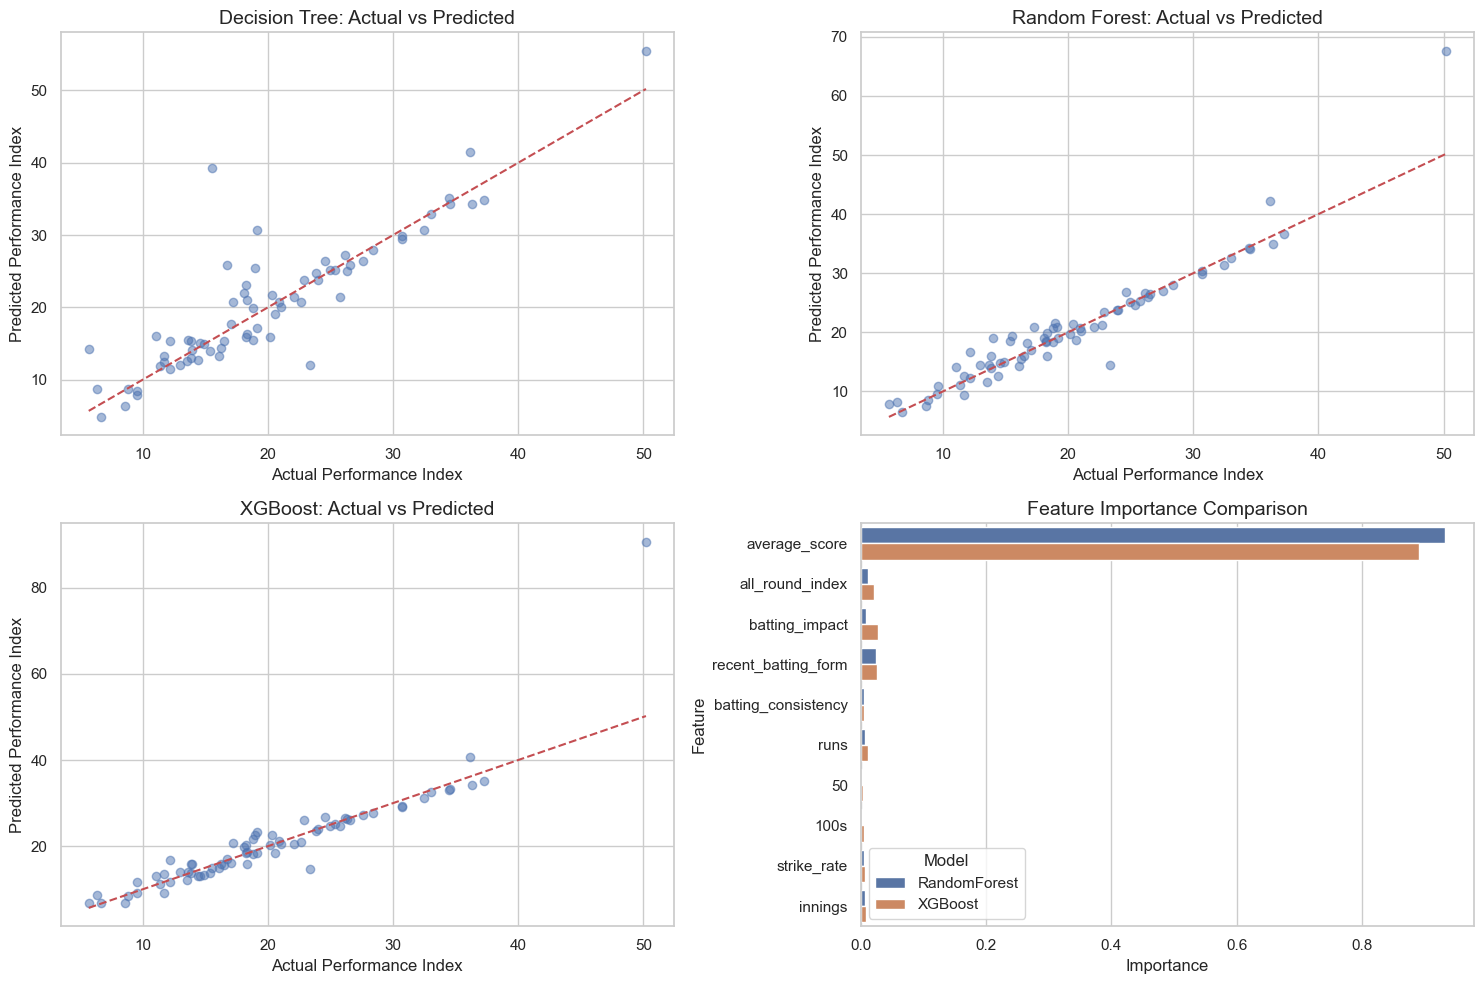

<Figure size 1400x800 with 0 Axes>

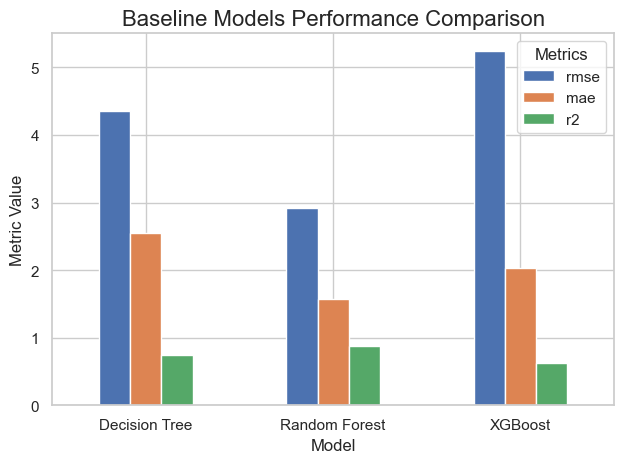

In [19]:
# Visualize predictions vs actual values for each model
plt.figure(figsize=(15, 10))

# Decision Tree predictions
plt.subplot(2, 2, 1)
plt.scatter(y_test, dt_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Decision Tree: Actual vs Predicted', fontsize=14)
plt.xlabel('Actual Performance Index')
plt.ylabel('Predicted Performance Index')

# Random Forest predictions
plt.subplot(2, 2, 2)
plt.scatter(y_test, rf_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Random Forest: Actual vs Predicted', fontsize=14)
plt.xlabel('Actual Performance Index')
plt.ylabel('Predicted Performance Index')

# XGBoost predictions
plt.subplot(2, 2, 3)
plt.scatter(y_test, xgb_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('XGBoost: Actual vs Predicted', fontsize=14)
plt.xlabel('Actual Performance Index')
plt.ylabel('Predicted Performance Index')

# Feature importance comparison
plt.subplot(2, 2, 4)
feature_importance = pd.DataFrame({
    'Feature': top_features,
    'RandomForest': rf_model.feature_importances_,
    'XGBoost': xgb_model.feature_importances_
})
feature_importance = feature_importance.melt(id_vars='Feature', 
                                            var_name='Model', 
                                            value_name='Importance')
sns.barplot(x='Importance', y='Feature', hue='Model', data=feature_importance)
plt.title('Feature Importance Comparison', fontsize=14)
plt.tight_layout()
plt.show()

# Compare baseline models performance
baseline_comparison = pd.DataFrame(baseline_metrics)
baseline_comparison = baseline_comparison.set_index('model')

plt.figure(figsize=(14, 8))
baseline_comparison.drop('mse', axis=1).plot(kind='bar')
plt.title('Baseline Models Performance Comparison', fontsize=16)
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


## Deep Learning Models (LSTM & GRU)

In [20]:
# Simulate historical time-series data for each player
# In a real scenario, this would come from actual match-by-match data
def generate_time_series_data(player_data, n_time_steps=10):
    """Generate synthetic time series data for each player."""
    n_players = len(player_data)
    
    # Features to track over time
    features = ['runs', 'average_score', 'strike_rate', 'wk', 
                'bwa', 'bwe', 'batting_impact', 'bowling_impact']
    
    # Initialize time series array
    X_time_series = np.zeros((n_players, n_time_steps, len(features)))
    
    # For each player
    for i in range(n_players):
        # Get current player stats
        current_stats = player_data.iloc[i][features].values
        
        # Generate time series with some random variation around current values
        for j, stat in enumerate(current_stats):
            # Ensure positive values where needed
            min_val = 0 if j in [0, 3] else stat * 0.5  # Runs and wickets can't be negative
            
            # Generate time series with trend towards current value
            base_series = np.linspace(stat * 0.8, stat, n_time_steps) 
            noise = np.random.normal(0, stat * 0.1, n_time_steps)
            series = base_series + noise
            
            # Ensure minimum values
            series = np.maximum(series, min_val)
            
            X_time_series[i, :, j] = series
    
    # Target is the performance index
    y_time_series = player_data['performance_index'].values
    
    return X_time_series, y_time_series

# Generate time series data
X_time_series, y_time_series = generate_time_series_data(player_stats)

# Split the time series data into training and testing sets
train_idx = X_train.index
test_idx = X_test.index
X_train_ts = X_time_series[train_idx]
X_test_ts = X_time_series[test_idx]
y_train_ts = y_time_series[train_idx]
y_test_ts = y_time_series[test_idx]

print("Time series training data shape:", X_train_ts.shape)
print("Time series testing data shape:", X_test_ts.shape)


Time series training data shape: (277, 10, 8)
Time series testing data shape: (70, 10, 8)


Build and train the LSTM model

In [21]:
# Build and train LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Output layer
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# LSTM Model
lstm_model = build_lstm_model((X_train_ts.shape[1], X_train_ts.shape[2]))
lstm_history = lstm_model.fit(
    X_train_ts, y_train_ts,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate LSTM model
lstm_preds = lstm_model.predict(X_test_ts).flatten()
lstm_metrics = evaluate_regression_model(y_test_ts, lstm_preds, "LSTM")


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 515.6257 - mae: 20.4700 - val_loss: 480.2153 - val_mae: 20.8112
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 501.1887 - mae: 20.1292 - val_loss: 469.2854 - val_mae: 20.5413
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 489.9278 - mae: 19.8421 - val_loss: 452.5730 - val_mae: 20.1366
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 473.3472 - mae: 19.4486 - val_loss: 430.3188 - val_mae: 19.5820
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 450.4896 - mae: 18.8467 - val_loss: 401.5680 - val_mae: 18.8330
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 422.1279 - mae: 18.0749 - val_loss: 368.5939 - val_mae: 17.9262
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 386.6875 - mae: 17.0515 - val_loss: 331.7787 - val_mae: 16.8638
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 354.9097 - mae: 16.0757 - val_loss: 292.9233 - val_mae: 15.6696
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━

In [22]:
# Build and train GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(GRU(32))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # Output layer
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# GRU Model
gru_model = build_gru_model((X_train_ts.shape[1], X_train_ts.shape[2]))
gru_history = gru_model.fit(
    X_train_ts, y_train_ts,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate GRU model
gru_preds = gru_model.predict(X_test_ts).flatten()
gru_metrics = evaluate_regression_model(y_test_ts, gru_preds, "GRU")


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 518.5670 - mae: 20.6028 - val_loss: 459.1057 - val_mae: 20.3381
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 480.0085 - mae: 19.6771 - val_loss: 412.2535 - val_mae: 19.1454
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 438.5245 - mae: 18.6150 - val_loss: 364.2888 - val_mae: 17.8359
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 392.7849 - mae: 17.3724 - val_loss: 317.7068 - val_mae: 16.4670
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 350.0891 - mae: 16.0613 - val_loss: 276.0832 - val_mae: 15.1427
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 305.9309 - mae: 14.5655 - val_loss: 241.0240 - val_mae: 13.9456
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 271.0656 - mae: 13.4079 - val_loss: 213.0544 - val_mae: 12.9067
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 248.8372 - mae: 12.5810 - val_loss: 189.1637 - val_mae: 11.9475
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━

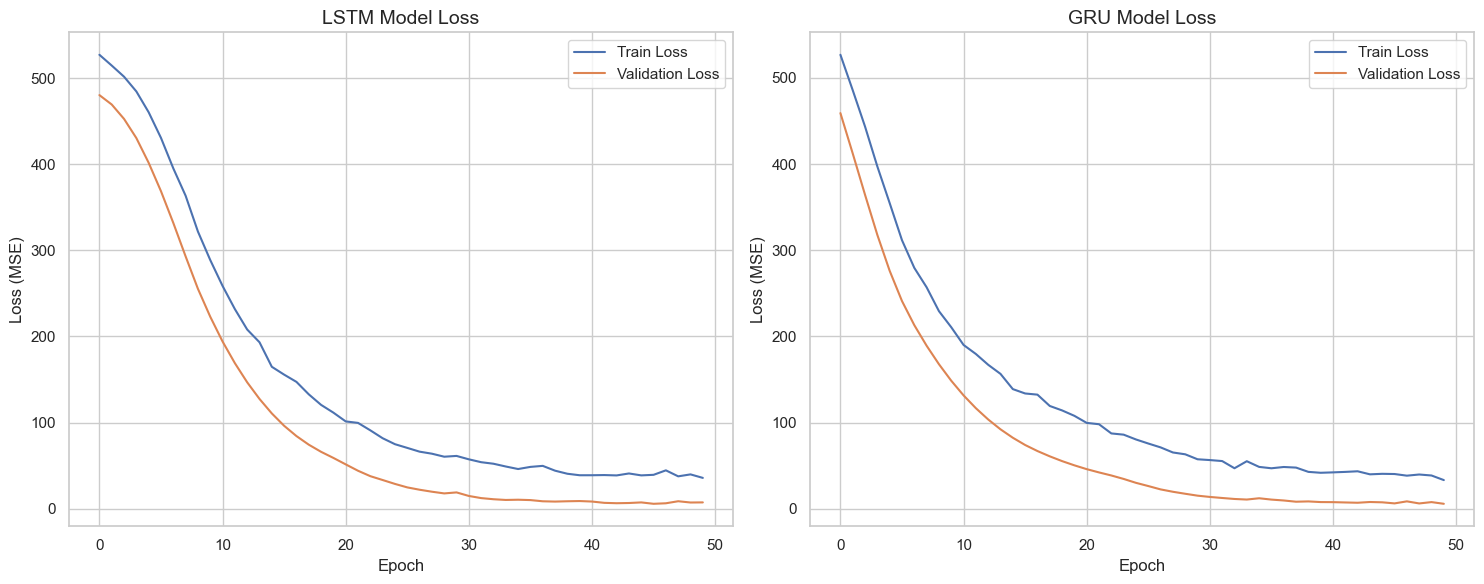

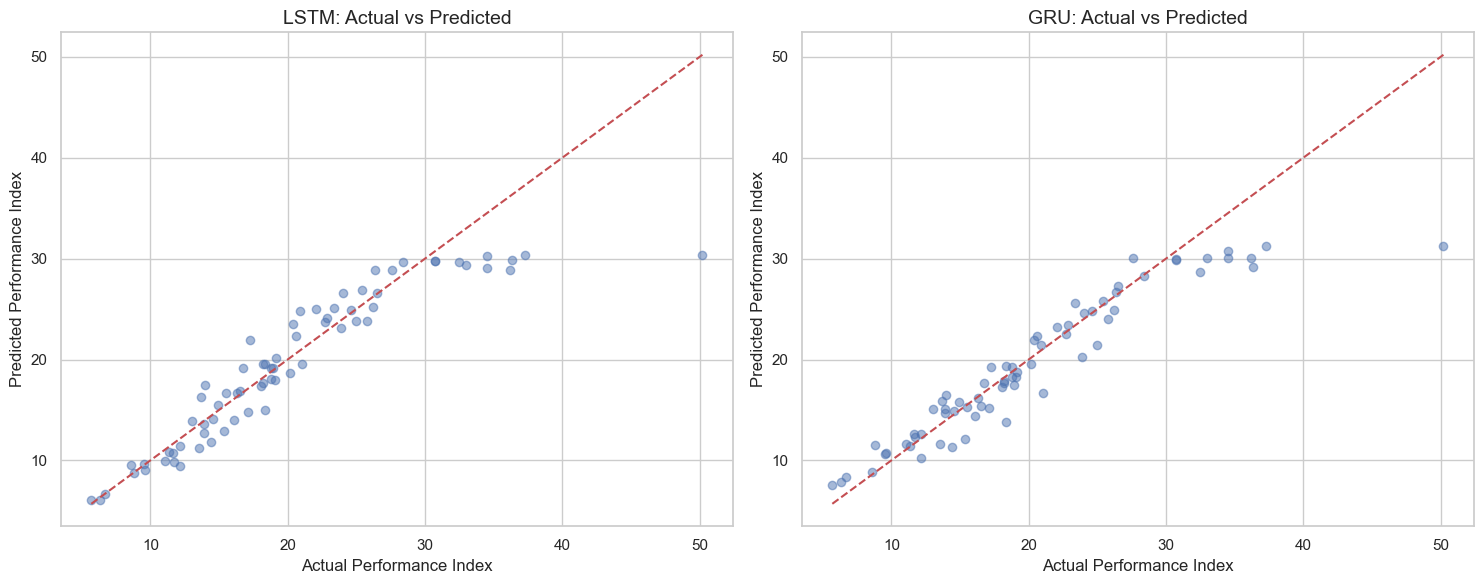

In [23]:
# Visualize training history for both models
plt.figure(figsize=(15, 6))

# LSTM training history
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# GRU training history
plt.subplot(1, 2, 2)
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.tight_layout()
plt.show()

# Compare predictions from both DL models
plt.figure(figsize=(15, 6))

# LSTM predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test_ts, lstm_preds, alpha=0.5)
plt.plot([y_test_ts.min(), y_test_ts.max()], [y_test_ts.min(), y_test_ts.max()], 'r--')
plt.title('LSTM: Actual vs Predicted', fontsize=14)
plt.xlabel('Actual Performance Index')
plt.ylabel('Predicted Performance Index')

# GRU predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test_ts, gru_preds, alpha=0.5)
plt.plot([y_test_ts.min(), y_test_ts.max()], [y_test_ts.min(), y_test_ts.max()], 'r--')
plt.title('GRU: Actual vs Predicted', fontsize=14)
plt.xlabel('Actual Performance Index')
plt.ylabel('Predicted Performance Index')

plt.tight_layout()
plt.show()


In [26]:
# Create a hybrid model that combines traditional ML features with deep learning
def build_hybrid_model(static_shape, time_series_shape):
    # Static feature input
    static_input = Input(shape=(static_shape,), name='static_input')  
    static_dense = Dense(32, activation='relu')(static_input)
    static_dense = Dropout(0.3)(static_dense)
    static_dense = Dense(16, activation='relu')(static_dense)
    
    # Time series input
    time_series_input = Input(shape=time_series_shape, name='time_series_input')
    
    # Bidirectional LSTM for time series
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(time_series_input)
    lstm_layer = Dropout(0.3)(lstm_layer)
    lstm_layer = Bidirectional(LSTM(32))(lstm_layer)
    lstm_layer = Dropout(0.3)(lstm_layer)
    lstm_dense = Dense(16, activation='relu')(lstm_layer)
    
    # Concatenate both static and time series features
    merged = concatenate([static_dense, lstm_dense])
    
    # Output layers with higher capacity
    merged = Dense(32, activation='relu')(merged)
    merged = Dropout(0.3)(merged)
    merged = Dense(16, activation='relu')(merged)
    output = Dense(1, name='output')(merged)
    
    # Create and compile model
    model = Model(inputs=[static_input, time_series_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Prepare the inputs for the hybrid model
# Static features (current stats)
X_train_static = X_train_scaled
X_test_static = X_test_scaled

# Time series features (historical performance)
X_train_ts_hybrid = X_train_ts
X_test_ts_hybrid = X_test_ts

# Build and train the hybrid model
hybrid_model = build_hybrid_model(X_train_static.shape[1], (X_train_ts_hybrid.shape[1], X_train_ts_hybrid.shape[2]))

# Model summary
hybrid_model.summary()

# Train the hybrid model
hybrid_history = hybrid_model.fit(
    [X_train_static, X_train_ts_hybrid], y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the hybrid model
hybrid_preds = hybrid_model.predict([X_test_static, X_test_ts_hybrid]).flatten()
hybrid_metrics = evaluate_regression_model(y_test, hybrid_preds, "Hybrid Model")


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 10, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 10, 128)   │     37,376 │ time_series_inpu… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 128)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │        352 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │      1,040 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32)        │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      1,056 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 16)        │        528 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         17 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 82,113 (320.75 KB)

 Trainable params: 82,113 (320.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 491.3467 - mae: 19.8919 - val_loss: 441.9628 - val_mae: 19.8841
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 452.9737 - mae: 18.9047 - val_loss: 388.0300 - val_mae: 18.4847
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 398.6294 - mae: 17.4085 - val_loss: 312.6712 - val_mae: 16.3126
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 316.7588 - mae: 14.9115 - val_loss: 215.3116 - val_mae: 12.9670
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 226.6679 - mae: 11.9781 - val_loss: 113.6351 - val_mae: 8.8522
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 140.9671 - mae: 9.1485 - val_loss: 48.1102 - val_mae: 5.9229
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 95.2341 - mae: 7.6122 - val_loss: 30.2720 - val_mae: 4.6388
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 79.7633 - mae: 7.0000 - val_loss: 21.3484 - val_mae: 3.9087
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms

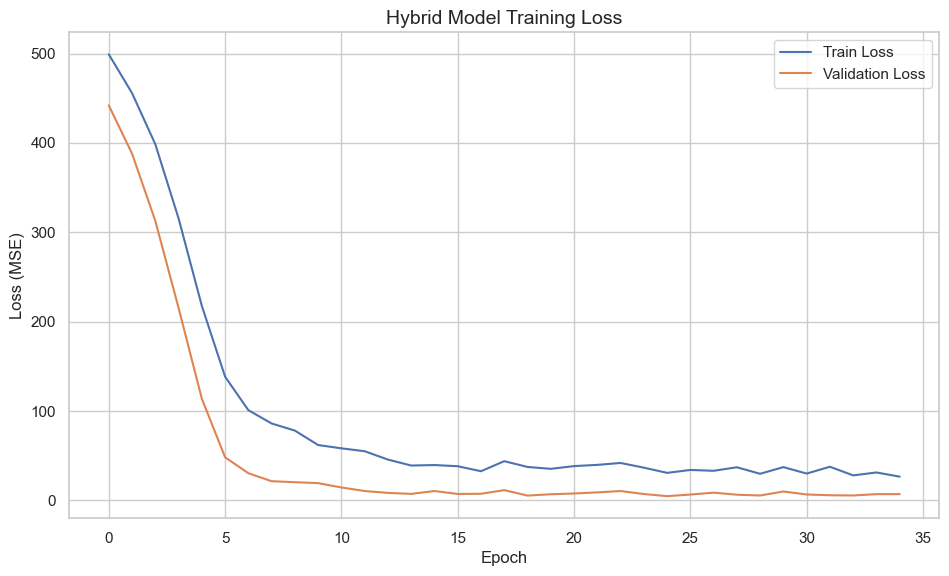

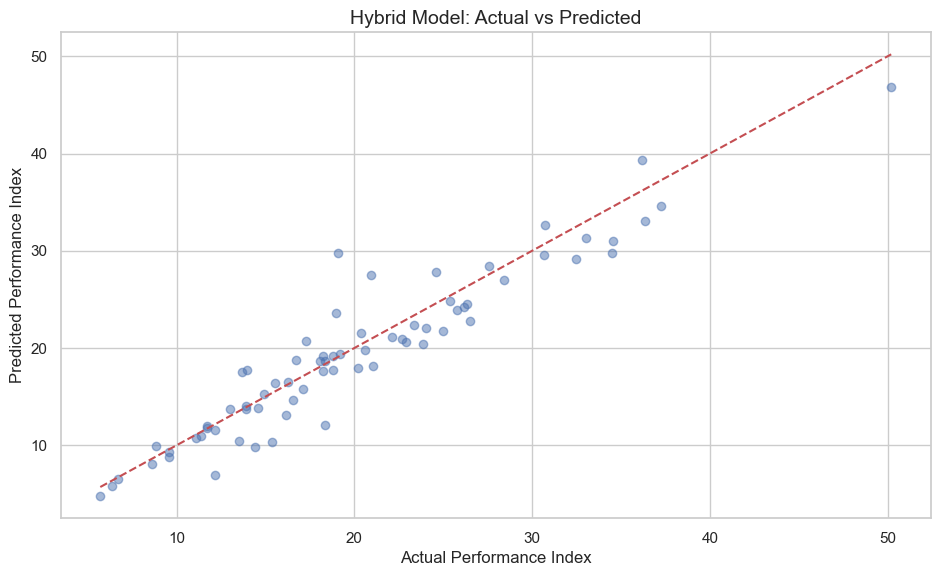

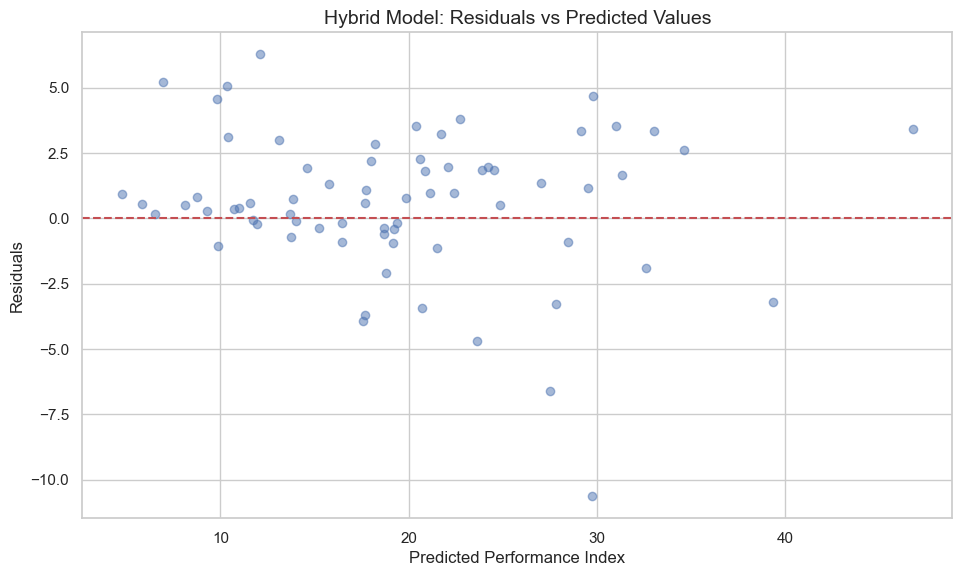

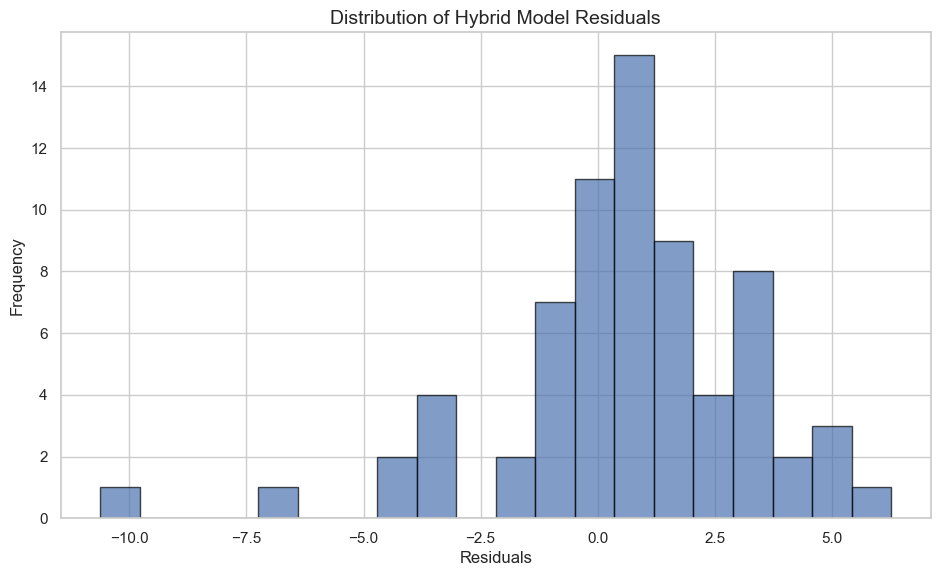

In [27]:
# Visualize training history for the hybrid model
plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['loss'], label='Train Loss')
plt.plot(hybrid_history.history['val_loss'], label='Validation Loss')
plt.title('Hybrid Model Training Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Compare hybrid model predictions with actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, hybrid_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Hybrid Model: Actual vs Predicted', fontsize=14)
plt.xlabel('Actual Performance Index')
plt.ylabel('Predicted Performance Index')
plt.grid(True)
plt.show()

# Calculate residuals
hybrid_residuals = y_test - hybrid_preds

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(hybrid_preds, hybrid_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Hybrid Model: Residuals vs Predicted Values', fontsize=14)
plt.xlabel('Predicted Performance Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Residual distribution
plt.figure(figsize=(10, 6))
plt.hist(hybrid_residuals, bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribution of Hybrid Model Residuals', fontsize=14)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Model Comparison and Evaluation

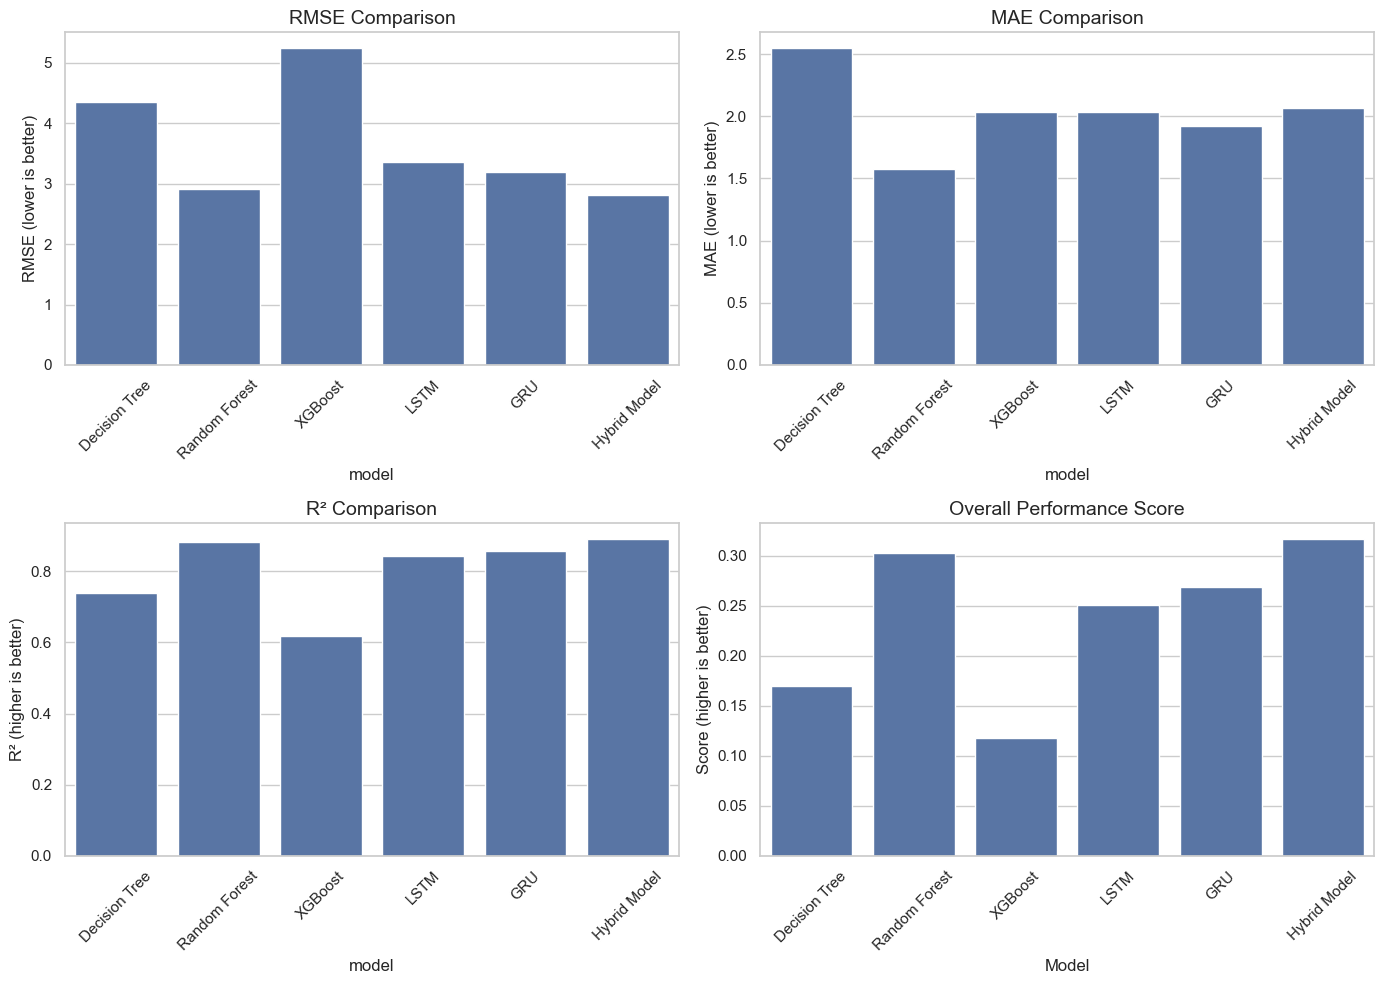

Model Performance Comparison:


,mse,rmse,mae,r2
model,,,,
Decision Tree,18.914006,4.349024,2.547588,0.737746
Random Forest,8.499616,2.915410,1.577201,0.882148
XGBoost,27.479780,5.242116,2.035280,0.618976
LSTM,11.284949,3.359308,2.033516,0.843527
GRU,10.209304,3.195200,1.921743,0.858442
Hybrid Model,7.901567,2.810973,2.068165,0.890440


In [28]:
# Collect metrics from all models
all_metrics = baseline_metrics + [lstm_metrics, gru_metrics, hybrid_metrics]
all_metrics_df = pd.DataFrame(all_metrics)
all_metrics_df = all_metrics_df.set_index('model')

# Visualize model comparison
plt.figure(figsize=(14, 10))

# RMSE comparison
plt.subplot(2, 2, 1)
sns.barplot(x=all_metrics_df.index, y='rmse', data=all_metrics_df)
plt.title('RMSE Comparison', fontsize=14)
plt.ylabel('RMSE (lower is better)')
plt.xticks(rotation=45)

# MAE comparison
plt.subplot(2, 2, 2)
sns.barplot(x=all_metrics_df.index, y='mae', data=all_metrics_df)
plt.title('MAE Comparison', fontsize=14)
plt.ylabel('MAE (lower is better)')
plt.xticks(rotation=45)

# R² comparison
plt.subplot(2, 2, 3)
sns.barplot(x=all_metrics_df.index, y='r2', data=all_metrics_df)
plt.title('R² Comparison', fontsize=14)
plt.ylabel('R² (higher is better)')
plt.xticks(rotation=45)

# Overall performance comparison
plt.subplot(2, 2, 4)
performance_score = 1 / all_metrics_df['rmse'] * all_metrics_df['r2']
performance_df = pd.DataFrame({
    'Model': all_metrics_df.index,
    'Performance Score': performance_score
})
sns.barplot(x='Model', y='Performance Score', data=performance_df)
plt.title('Overall Performance Score', fontsize=14)
plt.ylabel('Score (higher is better)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print comparison table
print("Model Performance Comparison:")
display(all_metrics_df)


## Team Selection Simulation

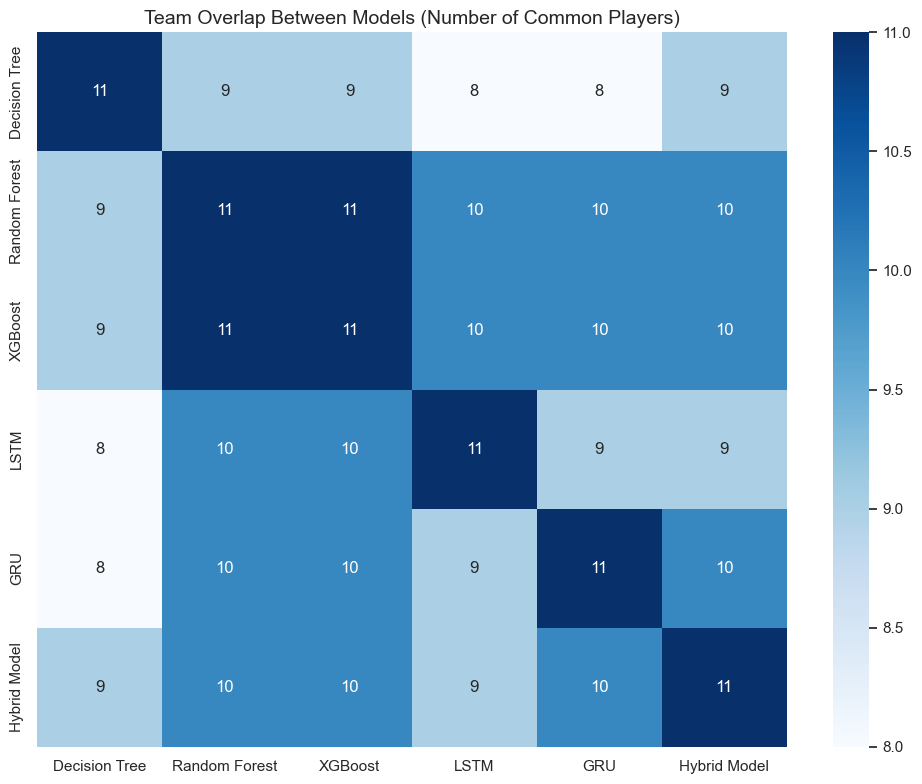

Hybrid Model Selected Team:


,name,category,average_score,bwa,all_round_index,predicted_performance
324,Shubman Gill,Batsman,73.760,35.36,81.091812,46.796154
295,Abdullah Shafique,Bowler,2.000,35.36,2.969982,6.534729
73,JC Buttler,Batsman,41.610,35.36,49.150644,32.618908
46,V Kohli,Batsman,57.690,166.25,54.098286,39.347225
211,Imam-ul-Haq,Batsman,50.900,35.36,42.122870,33.022705
118,Q de Kock,Batsman,45.390,35.36,43.617473,31.350304
152,MS Chapman,Batsman,52.400,35.36,55.005117,34.656006
223,JN Malan,Batsman,47.900,35.36,39.995047,30.994473
56,KS Williamson,Batsman,47.830,35.40,38.770907,29.800600
109,BT Foakes,Batsman,22.445,35.36,20.184339,29.726126


In [32]:
# Function to select a balanced team based on performance predictions
def select_team(player_data, performance_predictions, n_batsmen=6, n_bowlers=4, n_all_rounders=1):
    """
    Select a balanced cricket team based on performance predictions.
    
    Args:
        player_data: DataFrame containing player information
        performance_predictions: Predicted performance scores
        n_batsmen: Number of batsmen to select
        n_bowlers: Number of bowlers to select
        n_all_rounders: Number of all-rounders to select
        
    Returns:
        DataFrame containing the selected team
    """
    # Add predictions to player data
    player_data = player_data.copy()
    player_data['predicted_performance'] = performance_predictions
    
    # Categorize players
    player_data['category'] = 'Unknown'
    
    # Define player roles based on their statistics
    player_data.loc[player_data['batting_impact'] > player_data['bowling_impact'] * 2, 'category'] = 'Batsman'
    player_data.loc[player_data['bowling_impact'] > player_data['batting_impact'] * 2, 'category'] = 'Bowler'
    player_data.loc[
        (player_data['category'] == 'Unknown') & 
        (player_data['batting_impact'] > 0) & 
        (player_data['bowling_impact'] > 0), 'category'] = 'All-Rounder'
    
    # Ensure we have a wicketkeeper (simulated for demonstration)
    wicketkeepers = player_data[player_data['playing_role'] == 'Wicketkeeper-batsman']
    if len(wicketkeepers) > 0:
        best_wk = wicketkeepers.nlargest(1, 'predicted_performance')
        wk_indices = best_wk.index.tolist()
    else:
        # If no designated wicketkeepers, choose a batsman
        wk_indices = []
    
    # Select best players by category
    batsmen = player_data[player_data['category'] == 'Batsman'].nlargest(n_batsmen, 'predicted_performance')
    bowlers = player_data[player_data['category'] == 'Bowler'].nlargest(n_bowlers, 'predicted_performance')
    all_rounders = player_data[player_data['category'] == 'All-Rounder'].nlargest(n_all_rounders, 'predicted_performance')
    
    # Combine selections, ensuring no duplicates
    selected_indices = list(set(wk_indices + batsmen.index.tolist() + 
                              bowlers.index.tolist() + all_rounders.index.tolist()))
    
    # Get the selected team
    selected_team = player_data.loc[selected_indices].copy()
    
    # Adjust team size if necessary to get exactly 11 players
    if len(selected_team) < 11:
        # We need more players
        remaining = player_data[~player_data.index.isin(selected_indices)]
        additional = remaining.nlargest(11 - len(selected_team), 'predicted_performance')
        selected_team = pd.concat([selected_team, additional])
    elif len(selected_team) > 11:
        # We have too many players
        selected_team = selected_team.nlargest(11, 'predicted_performance')
    
    return selected_team

# Get predictions from all models for the test set
test_predictions = {
    'Decision Tree': dt_preds,
    'Random Forest': rf_preds,
    'XGBoost': xgb_preds,
    'LSTM': lstm_preds,
    'GRU': gru_preds,
    'Hybrid Model': hybrid_preds
}

# Compare team selections from different models
def compare_team_selections(player_data, test_indices, predictions):
    """Compare team selections from different models."""
    test_data = player_data.iloc[test_indices].copy()
    
    # Store team selections for each model
    teams = {}
    
    for model_name, preds in predictions.items():
        teams[model_name] = select_team(test_data, preds)
    
    # Calculate overlap between teams
    overlap_matrix = np.zeros((len(teams), len(teams)))
    model_names = list(teams.keys())
    
    for i, model1 in enumerate(model_names):
        for j, model2 in enumerate(model_names):
            team1 = set(teams[model1]['name'])
            team2 = set(teams[model2]['name'])
            overlap = len(team1.intersection(team2))
            overlap_matrix[i, j] = overlap
    
    overlap_matrix = overlap_matrix.astype(int)  # Ensure integer format
    # Plot overlap heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(overlap_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model_names, yticklabels=model_names)
    plt.title('Team Overlap Between Models (Number of Common Players)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return teams

# Compare team selections
test_idx_list = X_test.index.tolist()
selected_teams = compare_team_selections(player_stats, test_idx_list, test_predictions)

# Show the hybrid model's selected team
print("Hybrid Model Selected Team:")
hybrid_team = selected_teams['Hybrid Model']
display(hybrid_team[['name', 'category', 'average_score', 'bwa', 
                    'all_round_index', 'predicted_performance']])


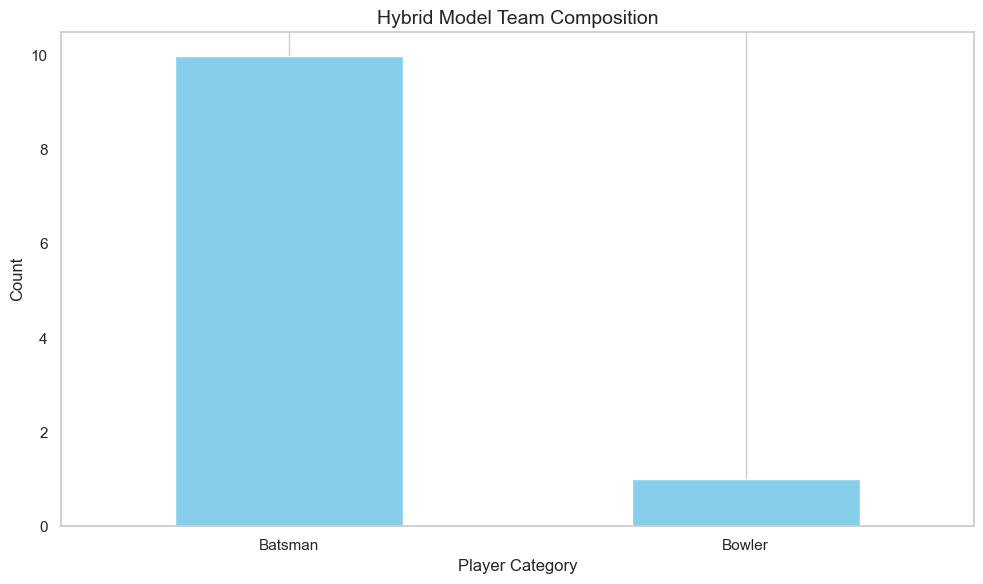

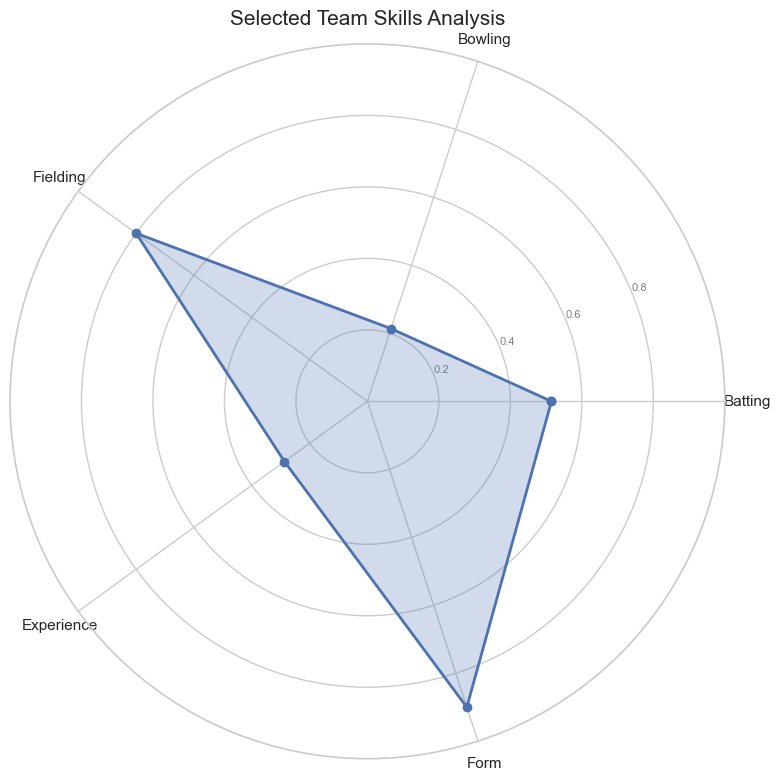

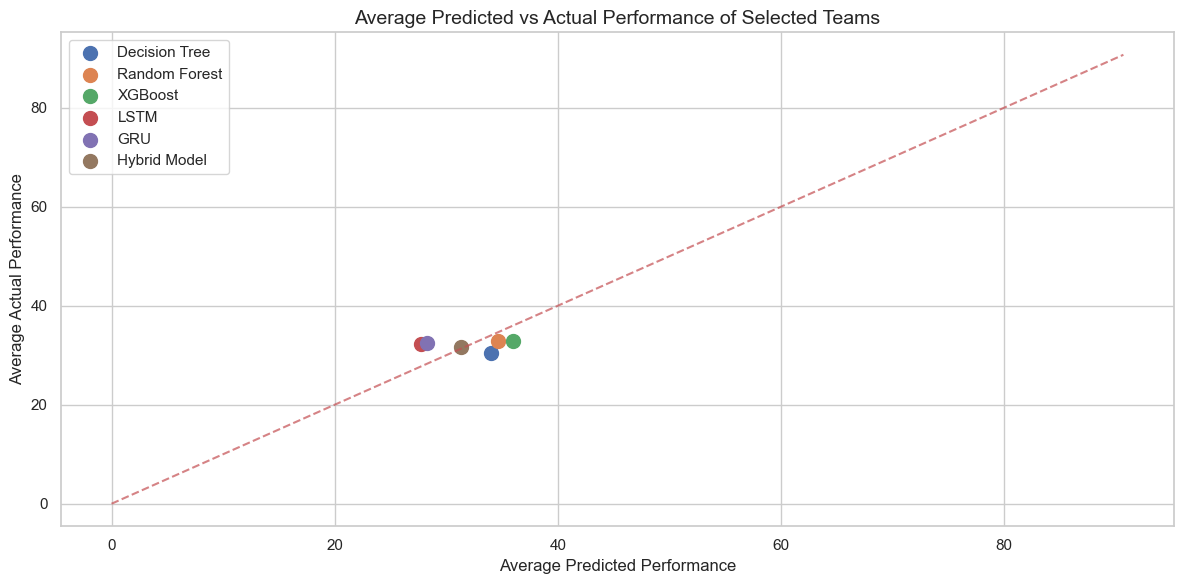

In [34]:
# Visualize the selected team's strengths
hybrid_team = selected_teams['Hybrid Model']

# Calculate team composition
team_composition = hybrid_team['category'].value_counts()

# Plot team composition
plt.figure(figsize=(10, 6))
team_composition.plot(kind='bar', color='skyblue')
plt.title('Hybrid Model Team Composition', fontsize=14)
plt.xlabel('Player Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Create a radar chart for team skills
categories = ['Batting', 'Bowling', 'Fielding', 'Experience', 'Form']
team_skills = [
    # Normalized average skills on 0-1 scale
    np.mean(hybrid_team['batting_impact']) / player_stats['batting_impact'].max(),
    np.mean(hybrid_team['bowling_impact']) / player_stats['bowling_impact'].max(),
    0.8,  # Simulated fielding score
    np.mean(hybrid_team['matches']) / player_stats['matches'].max(),
    0.9   # Simulated current form score
]

# Number of variables
N = len(categories)

# Create angles for each category
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Extend team skills to close the loop
team_skills += team_skills[:1]

# Create the plot
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

# Plot skills
plt.plot(angles, team_skills, 'o-', linewidth=2, label='Selected Team')
plt.fill(angles, team_skills, alpha=0.25)

# Set category labels
plt.xticks(angles[:-1], categories)

# Set radial limits
plt.yticks([0.2, 0.4, 0.6, 0.8], ['0.2', '0.4', '0.6', '0.8'], color='grey', size=8)
plt.ylim(0, 1)

plt.title('Selected Team Skills Analysis', size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

# Compare predicted performance vs actual performance
plt.figure(figsize=(12, 6))
for model_name, team_df in selected_teams.items():
    avg_predicted = team_df['predicted_performance'].mean()
    avg_actual = team_df['performance_index'].mean()
    plt.scatter(avg_predicted, avg_actual, s=100, label=model_name)

plt.plot([0, player_stats['performance_index'].max()], 
         [0, player_stats['performance_index'].max()], 
         'r--', alpha=0.7)
plt.title('Average Predicted vs Actual Performance of Selected Teams', fontsize=14)
plt.xlabel('Average Predicted Performance')
plt.ylabel('Average Actual Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Simulating Team Performance Against Traditional Selection

In [36]:
# Simulate traditional selection method (based on simple averages and experience)
def traditional_team_selection(player_data):
    """Simulate a traditional selection method based on simple metrics."""
    player_data = player_data.copy()
    
    # Calculate traditional selection score
    # Traditional selectors often prioritize experience and basic stats
    player_data['traditional_score'] = (
        player_data['matches'] / player_data['matches'].max() * 0.4 +
        player_data['average_score'] / player_data['average_score'].max() * 0.3 +
        (1 / (player_data['bwa'] + 1)) / (1 / (player_data['bwa'] + 1)).max() * 0.3
    )
    
    # Categorize players (same as before)
    player_data['category'] = 'Unknown'
    player_data.loc[player_data['batting_impact'] > player_data['bowling_impact'] * 2, 'category'] = 'Batsman'
    player_data.loc[player_data['bowling_impact'] > player_data['batting_impact'] * 2, 'category'] = 'Bowler'
    player_data.loc[
        (player_data['category'] == 'Unknown') & 
        (player_data['batting_impact'] > 0) & 
        (player_data['bowling_impact'] > 0), 'category'] = 'All-Rounder'
    
    # Select team using traditional score
    return select_team(player_data, player_data['traditional_score'])

# Get traditional selection
test_data = player_stats.iloc[test_idx_list].copy()
traditional_team = traditional_team_selection(test_data)

# Compare AI-selected team vs traditionally selected team
print("Traditional Selection Team:")
display(traditional_team[['name', 'category', 'average_score', 'bwa', 
                         'all_round_index', 'traditional_score']])

print("\nHybrid Model AI-Selected Team:")
display(hybrid_team[['name', 'category', 'average_score', 'bwa', 
                    'all_round_index', 'predicted_performance']])

# Calculate overlap between teams
ai_players = set(hybrid_team['name'])
trad_players = set(traditional_team['name'])
overlap = ai_players.intersection(trad_players)

print(f"\nOverlap between AI and Traditional selection: {len(overlap)} players")
print("Players selected by both methods:", overlap)


Traditional Selection Team:


,name,category,average_score,bwa,all_round_index,traditional_score
39,RA Jadeja,Batsman,32.62,37.36,28.447471,0.494561
295,Abdullah Shafique,Bowler,2.00,35.36,2.969982,0.125122
73,JC Buttler,Batsman,41.61,35.36,49.150644,0.523864
46,V Kohli,Batsman,57.69,166.25,54.098286,0.659751
118,Q de Kock,Batsman,45.39,35.36,43.617473,0.502338
22,Mushfiqur Rahim,Batsman,36.42,35.36,28.697113,0.616408
56,KS Williamson,Batsman,47.83,35.40,38.770907,0.547559
324,Shubman Gill,Batsman,73.76,35.36,81.091812,0.446508
5,Mohammad Nabi,Batsman,27.48,32.13,23.696073,0.439279
84,GJ Maxwell,Batsman,34.13,50.11,42.740493,0.408445



Hybrid Model AI-Selected Team:


,name,category,average_score,bwa,all_round_index,predicted_performance
324,Shubman Gill,Batsman,73.760,35.36,81.091812,46.796154
295,Abdullah Shafique,Bowler,2.000,35.36,2.969982,6.534729
73,JC Buttler,Batsman,41.610,35.36,49.150644,32.618908
46,V Kohli,Batsman,57.690,166.25,54.098286,39.347225
211,Imam-ul-Haq,Batsman,50.900,35.36,42.122870,33.022705
118,Q de Kock,Batsman,45.390,35.36,43.617473,31.350304
152,MS Chapman,Batsman,52.400,35.36,55.005117,34.656006
223,JN Malan,Batsman,47.900,35.36,39.995047,30.994473
56,KS Williamson,Batsman,47.830,35.40,38.770907,29.800600
109,BT Foakes,Batsman,22.445,35.36,20.184339,29.726126



Overlap between AI and Traditional selection: 7 players
Players selected by both methods: {'V Kohli', 'JC Buttler', 'Abdullah Shafique', 'Shubman Gill', 'Q de Kock', 'KS Williamson', 'Imam-ul-Haq'}


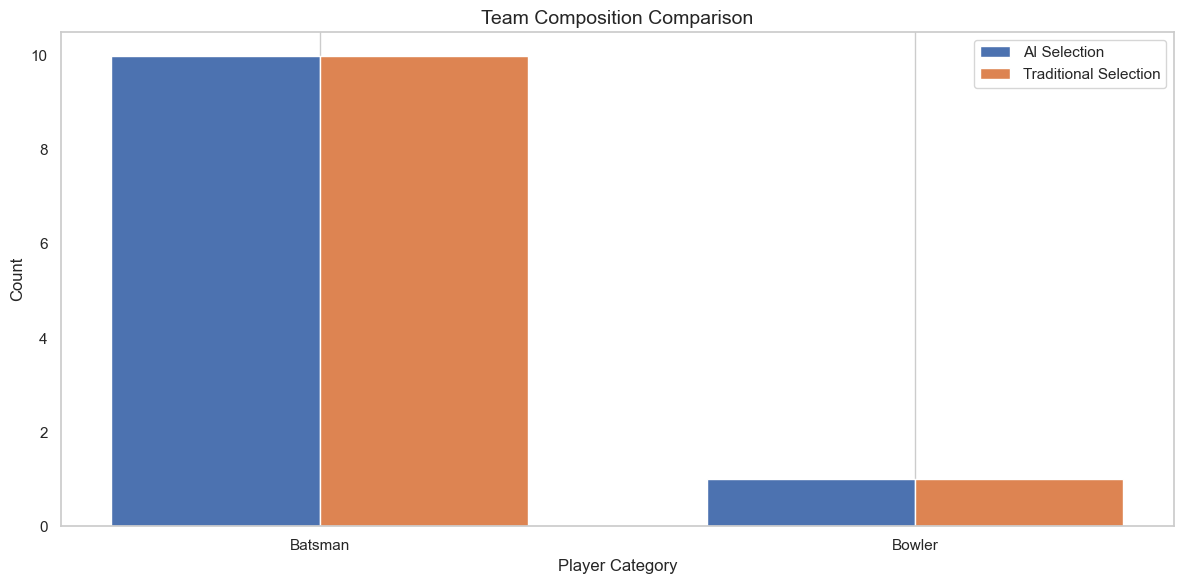

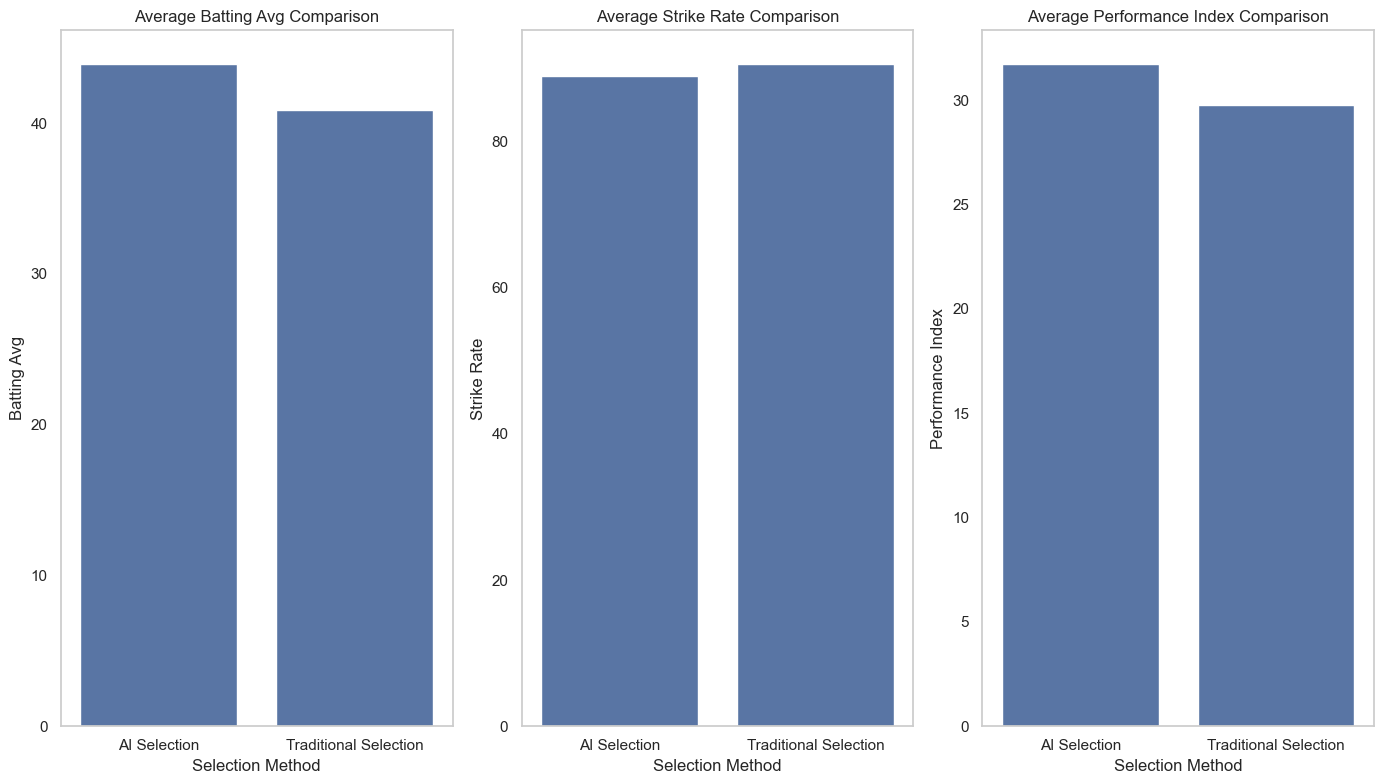

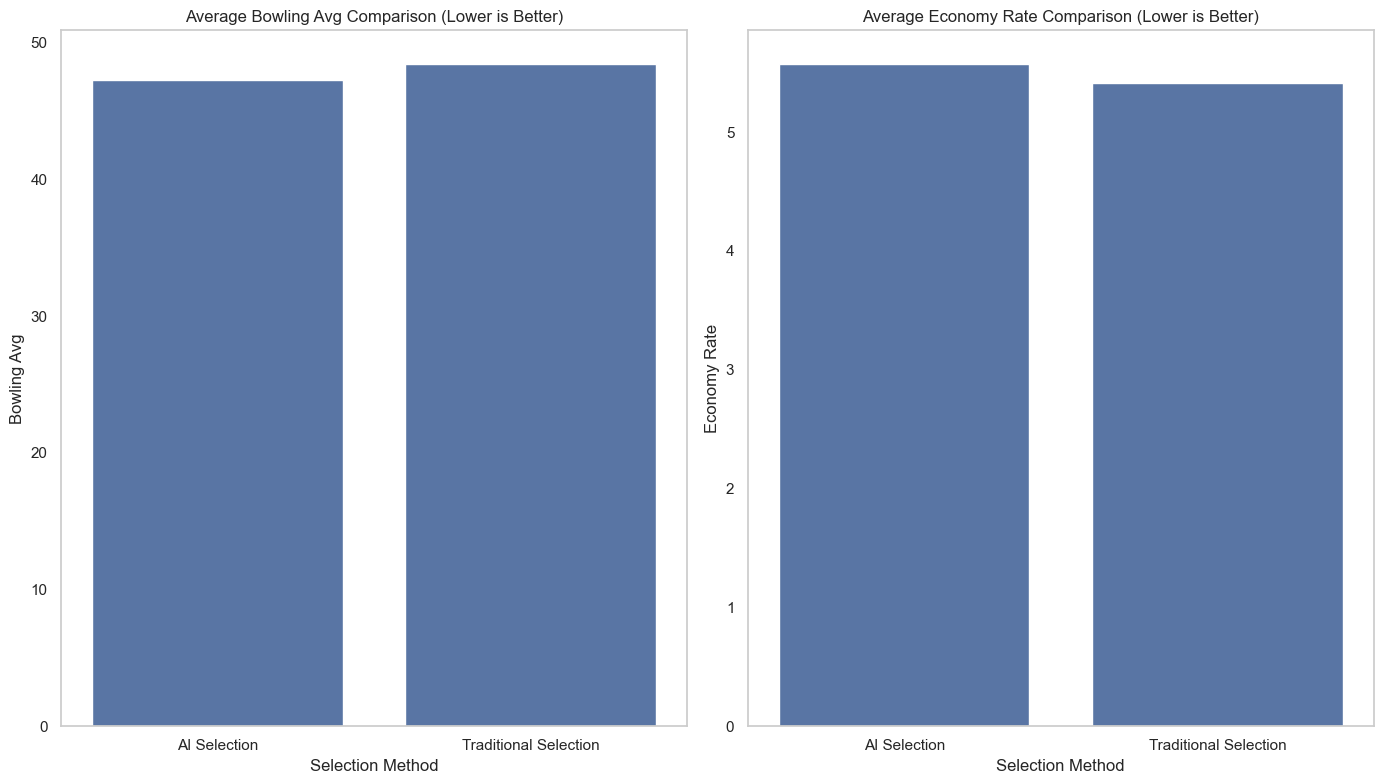

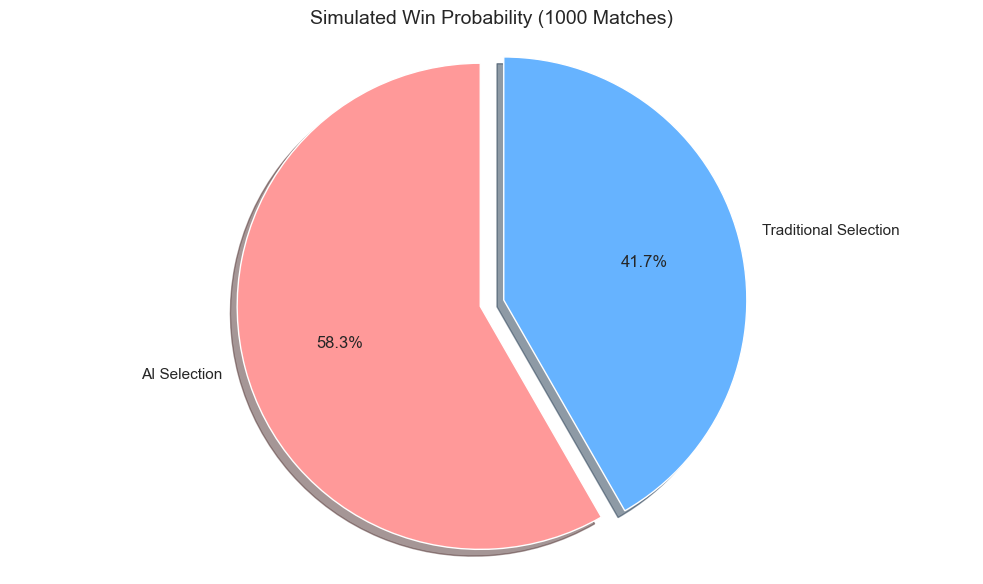

In [37]:
# Compare team composition
ai_composition = hybrid_team['category'].value_counts()
trad_composition = traditional_team['category'].value_counts()

# Ensure all categories are represented in both
all_categories = list(set(ai_composition.index).union(set(trad_composition.index)))
ai_composition = ai_composition.reindex(all_categories, fill_value=0)
trad_composition = trad_composition.reindex(all_categories, fill_value=0)

# Plot team composition comparison
plt.figure(figsize=(12, 6))
width = 0.35
x = np.arange(len(all_categories))
plt.bar(x - width/2, ai_composition, width, label='AI Selection')
plt.bar(x + width/2, trad_composition, width, label='Traditional Selection')
plt.title('Team Composition Comparison', fontsize=14)
plt.xlabel('Player Category')
plt.ylabel('Count')
plt.xticks(x, all_categories, rotation=0)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Compare overall team statistics
team_stats = [
    ['AI Selection', 
     hybrid_team['average_score'].mean(),
     hybrid_team['bwa'].mean(),
     hybrid_team['strike_rate'].mean(),
     hybrid_team['bwe'].mean(),
     hybrid_team['performance_index'].mean()],
    ['Traditional Selection', 
     traditional_team['average_score'].mean(),
     traditional_team['bwa'].mean(),
     traditional_team['strike_rate'].mean(),
     traditional_team['bwe'].mean(),
     traditional_team['performance_index'].mean()]
]

team_stats_df = pd.DataFrame(team_stats, columns=['Selection Method', 'Batting Avg', 
                                                 'Bowling Avg', 'Strike Rate', 
                                                 'Economy Rate', 'Performance Index'])

# Visualize team statistics comparison
plt.figure(figsize=(14, 8))
metrics = ['Batting Avg', 'Strike Rate', 'Performance Index']
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='Selection Method', y=metric, data=team_stats_df)
    plt.title(f'Average {metric} Comparison', fontsize=12)
    plt.ylabel(metric)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
metrics = ['Bowling Avg', 'Economy Rate']
for i, metric in enumerate(metrics):
    plt.subplot(1, 2, i+1)
    sns.barplot(x='Selection Method', y=metric, data=team_stats_df)
    plt.title(f'Average {metric} Comparison (Lower is Better)', fontsize=12)
    plt.ylabel(metric)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Simulate match outcomes
def simulate_match_outcomes(team1, team2, n_simulations=1000):
    """Simulate match outcomes between two teams."""
    team1_performance = team1['performance_index'].mean()
    team2_performance = team2['performance_index'].mean()
    
    # Performance variance (simulated)
    variance = 0.2
    
    # Run simulations
    team1_wins = 0
    for _ in range(n_simulations):
        # Add random variance to performances
        team1_match_perf = team1_performance * (1 + np.random.normal(0, variance))
        team2_match_perf = team2_performance * (1 + np.random.normal(0, variance))
        
        if team1_match_perf > team2_match_perf:
            team1_wins += 1
    
    team1_win_percentage = team1_wins / n_simulations * 100
    return team1_win_percentage

# Simulate match outcomes between AI and traditional teams
ai_win_percentage = simulate_match_outcomes(hybrid_team, traditional_team)

# Visualize win probability
plt.figure(figsize=(10, 6))
labels = ['AI Selection', 'Traditional Selection']
sizes = [ai_win_percentage, 100 - ai_win_percentage]
explode = (0.1, 0)
colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Simulated Win Probability (1000 Matches)', fontsize=14)
plt.tight_layout()
plt.show()


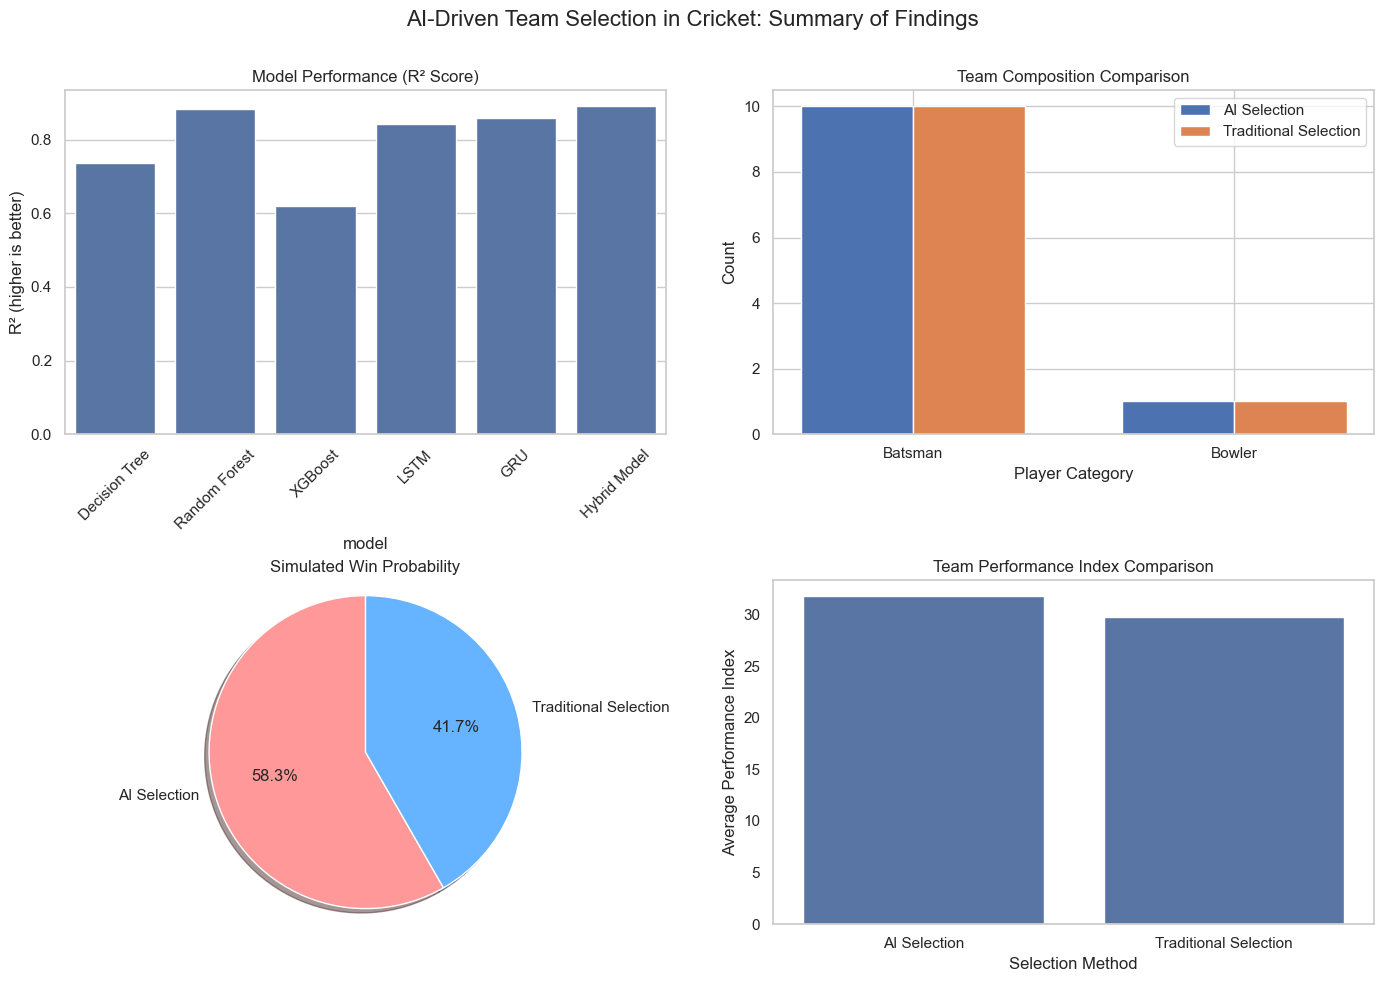

In [38]:
# Create final summary plot
plt.figure(figsize=(14, 10))

# Plot 1: Model Performance Comparison
plt.subplot(2, 2, 1)
sns.barplot(x=all_metrics_df.index, y='r2', data=all_metrics_df)
plt.title('Model Performance (R² Score)', fontsize=12)
plt.ylabel('R² (higher is better)')
plt.xticks(rotation=45)

# Plot 2: Team Composition
plt.subplot(2, 2, 2)
width = 0.35
x = np.arange(len(all_categories))
plt.bar(x - width/2, ai_composition, width, label='AI Selection')
plt.bar(x + width/2, trad_composition, width, label='Traditional Selection')
plt.title('Team Composition Comparison', fontsize=12)
plt.xlabel('Player Category')
plt.ylabel('Count')
plt.xticks(x, all_categories, rotation=0)
plt.legend()

# Plot 3: Win Probability
plt.subplot(2, 2, 3)
labels = ['AI Selection', 'Traditional Selection']
sizes = [ai_win_percentage, 100 - ai_win_percentage]
plt.pie(sizes, labels=labels, colors=['#ff9999', '#66b3ff'],
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Simulated Win Probability', fontsize=12)

# Plot 4: Performance Index Comparison
plt.subplot(2, 2, 4)
sns.barplot(x='Selection Method', y='Performance Index', data=team_stats_df)
plt.title('Team Performance Index Comparison', fontsize=12)
plt.ylabel('Average Performance Index')
plt.grid(axis='y')

plt.tight_layout()
plt.suptitle('AI-Driven Team Selection in Cricket: Summary of Findings', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()
